## 中证1000

### Part 1: Liquidity Risk Premium

#### Imports and Libraries

In [1]:
!pip install jqdatasdk
!pip install statsmodels
!pip install statsmodels --upgrade
!pip install empyrical
!pip install cvxopt

In [2]:
from jqdatasdk import *
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from collections import OrderedDict
import numpy.linalg
import statsmodels.api as sm 
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import warnings
warnings.filterwarnings('ignore')
import cvxopt
from cvxopt import solvers
import matplotlib.pyplot as plt
#warnings.filterwarnings('ignore')
from empyrical import max_drawdown,annual_return,sharpe_ratio,cum_returns

In [3]:
# auth('','')  

#### Data Gathering （读取一次即可，已存为CSV文件）

In [20]:
# 获取交易日
date_series = get_trade_days(start_date = "2018-01-01", end_date = "2022-02-01")

run jqdatasdk.auth first


In [21]:
# # 从聚宽读取中证1000的成分股,申万一级行业和其权重
# # 存入'zz1000_wi.csv'
# zz1000_df = pd.DataFrame()

# for i in date_series:
#   # weight
#   weight = get_index_weights('000300.XSHG', date = i).reset_index()
#   weight['date'] = i
  
#   # 申万一级行业分类
#   ind_dict = get_industry(list(weight['index']),date=i)
#   key_list = []
#   value_list = []
  
#   for key, value in ind_dict.items():
#       key_list.append(key)
#       value_list.append(value['sw_l1'])
      
#   industry = pd.DataFrame(value_list,index = key_list).reset_index()#.rename(columns = {'index':'code'})
  
#   # merge weight and industry table
#   w_i_df = weight.merge(industry,on = 'index', how = 'left')
#   w_i_df['date'] = w_i_df['date'].astype('datetime64[ns]')
  
#   # merge all date values
#   zz1000_df = zz1000_df.append(w_i_df,ignore_index=True)    

# # rename column names
# zz1000_df = zz1000_df.rename(columns = {'index':'code'})
    
# # zz1000_df.to_csv('zz1000_wi.csv')

In [22]:
# 获取市值
# all_cap_df = pd.DataFrame()
# for i in date_series:
#   cap_df = get_fundamentals(query(valuation.code,
#                                     valuation.day,
#                                     valuation.market_cap
#   ).filter(valuation.code.in_(code_list)), date = i)   

#   cap_df.rename(columns = {'day':'date'},inplace = True)
#   cap_df['date'] = cap_df['date'].astype('datetime64[ns]')
#   all_cap_df = all_cap_df.append(cap_df,ignore_index=True)
    
# all_cap_df['date'] = all_cap_df['date'].astype('datetime64[ns]')

In [23]:
# 获取中证1000的所有成分股过去时间的量价数据
# zz1000_panel =  get_price(list(code_list),
#                           start_date = '2018-01-01', 
#                           end_date = '2022-02-01', 
#                           frequency = 'daily', 
#                           fields = ['open','close','volume', 'money'], 
#                           skip_paused = False, 
#                           fq = 'pre', 
#                           panel = False) 
# zz1000_panel.rename(columns = {'time':'date'},inplace = True)
# zz1000_panel['date'] = zz1000_panel['date'].astype('datetime64[ns]')

In [24]:
# 合并市值和量价表
# 存入'zz1000_final.csv'
# zz1000 = pd.merge(zz1000_panel,all_cap_df, on = ['code','date'], how = 'right')
# zz1000.sort_values(by = ['code','date'],inplace=True)
# zz1000.to_csv('zz1000_final.csv')

#### 读取数据

In [4]:
# 读取股票每日行情的csv file
zz1000_panel_df = pd.read_csv('zz1000_final.csv').drop("Unnamed: 0", axis = 1)
zz1000_panel_df_copy = copy.deepcopy(zz1000_panel_df)

# 剔除停牌股票
zz1000_panel_df_copy = zz1000_panel_df_copy.replace(to_replace = 0, method = 'ffill') # 判断是否是调入后首日停牌
zz1000_panel_df_copy = zz1000_panel_df_copy[(zz1000_panel_df_copy != 0).all(1)] # 剔除首日停牌的股票
zz1000_panel_df_copy = zz1000_panel_df_copy.reset_index(drop = True)

#展示table
zz1000_panel_df_copy

,date,code,open,close,volume,money,market_cap
0,2018-03-08,000006.XSHE,7.78,7.78,6641726.0,5.167218e+07,119.7446
1,2018-03-09,000006.XSHE,7.55,7.72,127627854.0,9.711673e+08,118.7996
2,2018-03-12,000006.XSHE,7.55,7.59,84176446.0,6.359677e+08,116.7746
3,2018-03-13,000006.XSHE,7.59,7.63,69293524.0,5.308330e+08,117.4496
4,2018-03-14,000006.XSHE,7.50,7.27,68009370.0,5.023969e+08,111.9146
...,...,...,...,...,...,...,...
1635657,2022-01-24,688788.XSHG,123.80,125.61,436327.0,5.450238e+07,94.8785
1635658,2022-01-25,688788.XSHG,125.66,121.68,535705.0,6.644556e+07,91.9101
1635659,2022-01-26,688788.XSHG,121.72,111.80,1256421.0,1.442387e+08,84.4473
1635660,2022-01-27,688788.XSHG,111.00,107.77,721615.0,7.843767e+07,81.4032


#### 合成 Liquidity Risk Premium

In [5]:
def data_process(table, freq):
  '''
    计算组成因子所需的所有数据：
    Parameters:
    table:
      输入的panda table
    freq:
      策略频率
  '''

  df = copy.deepcopy(table)
  stock_list = list(df['code'].unique())
  df['money'] = df['money']/10e6 # 成交量的单位换位为百万元

  # create empty columns
  if freq == 'daily':
    df['daily_return'] = np.zeros(df.shape[0])
    df['daily_ILLIQ'] = np.zeros(df.shape[0])
    df['daily_P'] = np.zeros(df.shape[0])
    df['daily_C'] = np.zeros(df.shape[0])
    df['daily_residuals'] = np.zeros(df.shape[0])

  if freq == 'weekly':
    df['weekly_return'] = np.zeros(df.shape[0])
    df['weekly_ILLIQ'] = np.zeros(df.shape[0])
    df['weekly_P'] = np.zeros(df.shape[0])
    df['weekly_C'] = np.zeros(df.shape[0])
    df['weekly_residuals'] = np.zeros(df.shape[0])

  if freq == 'monthly':
    df['monthly_return'] = np.zeros(df.shape[0])
    df['monthly_ILLIQ'] = np.zeros(df.shape[0])
    df['monthly_P'] = np.zeros(df.shape[0])
    df['monthly_C'] = np.zeros(df.shape[0])
    df['monthly_residuals'] = np.zeros(df.shape[0])

  for stock in stock_list:
    temp_index = df[df["code"] == stock].index

    # calculate daily return
    if freq == 'daily':

      # 计算liquidity cost
      df['daily_return'].loc[temp_index] = df["close"].loc[temp_index].pct_change(1)
      df['daily_ILLIQ'].loc[temp_index] = df['daily_return'].loc[temp_index].abs()/df['money'].loc[temp_index]
      df['daily_P'].loc[temp_index] = df["market_cap"].loc[temp_index].shift(1)/df['market_cap'].loc[temp_index].tolist()[0] 
      df['daily_C'].loc[temp_index] = np.minimum(np.array(0.25 + 0.3*df['daily_ILLIQ'].loc[temp_index]*df['daily_P'].loc[temp_index]), 30*np.ones(len(temp_index)))

      # forward/back fill nan for each stock by previous/next value
      df.loc[temp_index] = df.loc[temp_index].ffill(axis = 0)
      df.loc[temp_index] = df.loc[temp_index].bfill(axis = 0)

      # calculate daily innovations
      model = AutoReg(df['daily_C'].loc[temp_index].values, lags = 20).fit()
      preds = model.predict()
      df['daily_residuals'].loc[temp_index] = df['daily_C'].loc[temp_index].values - preds

    # calculate weekly return
    if freq == 'weekly':

      # 计算liquidity cost
      df['weekly_return'].loc[temp_index] = df["close"].loc[temp_index].pct_change(5) 
      df['weekly_ILLIQ'].loc[temp_index] = df['weekly_return'].loc[temp_index]/df['money'].loc[temp_index]
      df['weekly_P'].loc[temp_index] = df["market_cap"].loc[temp_index].shift(1)/df['market_cap'].loc[temp_index].tolist()[0]
      df['weekly_C'].loc[temp_index] = np.minimum(np.array(0.25 + 0.3*df['weekly_ILLIQ'].loc[temp_index]*df['weekly_P'].loc[temp_index]), 30*np.ones(len(temp_index)))

      # forward/back fill nan for each stock by previous/next value
      df.loc[temp_index] = df.loc[temp_index].ffill(axis = 0)
      df.loc[temp_index] = df.loc[temp_index].bfill(axis = 0)

      # calculate weekly innovations
      model = AutoReg(df['weekly_C'].loc[temp_index], lags = 20).fit()
      preds = model.predict()
      df['weekly_residuals'].loc[temp_index] = df['weekly_C'].loc[temp_index].values - preds

    # calculate monthly return
    if freq == 'monthly':

      # 计算liquidity cost
      df['monthly_return'].loc[temp_index] = df["close"].loc[temp_index].pct_change(21) # 1 for ONE MOMTH lookback
      df['monthly_ILLIQ'].loc[temp_index] = df['monthly_return'].loc[temp_index]/df['money'][temp_index]
      df['monthly_P'].loc[temp_index] = df["market_cap"].loc[temp_index].shift(1)/df['market_cap'].loc[temp_index].tolist()[0]
      df['monthly_C'].loc[temp_index] = np.minimum(np.array(0.25 + 0.3*df['monthly_ILLIQ'].loc[temp_index]*df['monthly_P'].loc[temp_index]), 30*np.ones(len(temp_index)))

      # forward/backward fill nan for each stock by previous/next value
      df.loc[temp_index] = df.loc[temp_index].ffill(axis = 0)
      df.loc[temp_index] = df.loc[temp_index].bfill(axis = 0)

      # calculate monthly innovations
      model = AutoReg(df['monthly_C'].loc[temp_index], lags = 20).fit()
      preds = model.predict()
      df['monthly_residuals'].loc[temp_index] = df['monthly_C'].loc[temp_index].values - preds

  df["date"] = df["date"].astype("datetime64[ns]")
  df = df.dropna()
            
  return df

In [6]:
# 计算因子的各类数据
data_processed_df = data_process(zz1000_panel_df_copy, 'daily')

In [7]:
data_processed_df

,date,code,open,close,volume,money,market_cap,daily_return,daily_ILLIQ,daily_P,daily_C,daily_residuals
20,2018-04-09,000006.XSHE,6.26,6.31,18404664.0,11.513479,97.0646,0.006380,0.000554,0.806087,0.250134,-0.000242
21,2018-04-10,000006.XSHE,6.32,6.40,18902116.0,11.976298,98.5496,0.014263,0.001191,0.810597,0.250290,-0.000014
22,2018-04-11,000006.XSHE,6.42,6.38,18861569.0,12.104447,98.1446,-0.003125,0.000258,0.822998,0.250064,-0.000279
23,2018-04-12,000006.XSHE,6.36,6.26,14563910.0,9.180771,96.3896,-0.018809,0.002049,0.819616,0.250504,0.000209
24,2018-04-13,000006.XSHE,6.37,6.39,21064476.0,13.475654,98.4146,0.020767,0.001541,0.804960,0.250372,0.000027
...,...,...,...,...,...,...,...,...,...,...,...,...
1635657,2022-01-24,688788.XSHG,123.80,125.61,436327.0,5.450238,94.8785,0.005685,0.001043,0.568995,0.250178,-0.000297
1635658,2022-01-25,688788.XSHG,125.66,121.68,535705.0,6.644556,91.9101,-0.031287,0.004709,0.572229,0.250808,0.000286
1635659,2022-01-26,688788.XSHG,121.72,111.80,1256421.0,14.423865,84.4473,-0.081197,0.005629,0.554326,0.250936,0.000483
1635660,2022-01-27,688788.XSHG,111.00,107.77,721615.0,7.843767,81.4032,-0.036047,0.004596,0.509316,0.250702,0.000179


In [8]:
# 计算每日innovation均值
data_processed_df_copy = data_processed_df
grouped_multiple = data_processed_df_copy.groupby(['date']).agg({'daily_residuals': ['mean']})
grouped_multiple.columns = ['daily_innovation_mean']
grouped_multiple = grouped_multiple.reset_index()
grouped_multiple["date"]= grouped_multiple["date"].astype("datetime64[ns]")
grouped_multiple

,date,daily_innovation_mean
0,2018-01-30,-0.000330
1,2018-01-31,0.000468
2,2018-02-01,0.000861
3,2018-02-02,-0.000263
4,2018-02-05,-0.000228
...,...,...
967,2022-01-24,0.000017
968,2022-01-25,0.000755
969,2022-01-26,-0.000205
970,2022-01-27,0.000606


In [9]:
# 读取沪深300行情, 2年期国债YTM以及excess return
other_data_df = pd.read_csv('other_data.csv').dropna()
other_data_df["date"] = other_data_df["date"].astype("datetime64[ns]")
other_data_df['excess_return'] = other_data_df['excess_return'].astype('float')
other_data_df = other_data_df[["date",'excess_return']]
other_data_df

,date,excess_return
0,2018-01-02,-3.71183
1,2018-01-03,-3.71063
2,2018-01-04,-3.67296
3,2018-01-05,-3.62879
4,2018-01-08,-3.60553
...,...,...
1047,2022-03-22,-2.34321
1048,2022-03-23,-2.34041
1049,2022-03-24,-2.33900
1050,2022-03-25,-2.34155


In [10]:
# 合并表格
merged_df = grouped_multiple.merge(other_data_df,on = 'date', how = 'left')
merged_df["excess_return"] = merged_df["excess_return"].ffill(axis = 0)
merged_df["diff"] = merged_df["excess_return"] - merged_df["daily_innovation_mean"]
merged_df

,date,daily_innovation_mean,excess_return,diff
0,2018-01-30,-0.000330,-3.58987,-3.589540
1,2018-01-31,0.000468,-3.52425,-3.524718
2,2018-02-01,0.000861,-3.50942,-3.510281
3,2018-02-02,-0.000263,-3.51223,-3.511967
4,2018-02-05,-0.000228,-3.55182,-3.551592
...,...,...,...,...
967,2022-01-24,0.000017,-2.12065,-2.120667
968,2022-01-25,0.000755,-2.18392,-2.184675
969,2022-01-26,-0.000205,-2.18376,-2.183555
970,2022-01-27,0.000606,-2.20072,-2.201326


In [11]:
# liquidity risk is estimated using daily observations with a 6-month rolling window.
window = 126 # 6-month rolling window
merged_df_2 = merged_df.merge(pd.DataFrame(merged_df["diff"].rolling(window, 
              min_periods = 1).apply(lambda x: (x < 0).count())).rename(
                  columns = {'diff':'rolling_count'}),
                  how = 'left',
                  left_index = True,
                  right_index = True)
merged_df_2

,date,daily_innovation_mean,excess_return,diff,rolling_count
0,2018-01-30,-0.000330,-3.58987,-3.589540,1.0
1,2018-01-31,0.000468,-3.52425,-3.524718,2.0
2,2018-02-01,0.000861,-3.50942,-3.510281,3.0
3,2018-02-02,-0.000263,-3.51223,-3.511967,4.0
4,2018-02-05,-0.000228,-3.55182,-3.551592,5.0
...,...,...,...,...,...
967,2022-01-24,0.000017,-2.12065,-2.120667,126.0
968,2022-01-25,0.000755,-2.18392,-2.184675,126.0
969,2022-01-26,-0.000205,-2.18376,-2.183555,126.0
970,2022-01-27,0.000606,-2.20072,-2.201326,126.0


In [12]:
# 挑出需要计算liquidity risk premium的天数
time = merged_df_2[merged_df_2['rolling_count'].gt(15)]['date'].tolist()
stock_list = data_processed_df_copy["code"].unique()
all_stock_factors_df = pd.DataFrame(columns = ['date','code','liquidity_risk_premium'])

# 计算个股的liquidity risk premium
for i in stock_list:
  result_df = data_processed_df_copy[data_processed_df_copy['code'] == i].reset_index(drop = True)
  factor_df = result_df.merge(merged_df_2, on = ['date'], how = 'left')
  factor_df["diff_SQR"] = factor_df["diff"]**2
  factor_df["numerator"] = (-1)*factor_df["diff"]*factor_df['daily_C']
  factor_df["liquidity_risk_premium"] = factor_df["numerator"].rolling(window).sum()/factor_df["diff_SQR"].rolling(window).sum()
  factor_df = factor_df[['date','code','liquidity_risk_premium']].dropna()
  all_stock_factors_df = all_stock_factors_df.append(factor_df)

# 合并所有表格，用于因子中性化
all_stock_factors_df = all_stock_factors_df.reset_index(drop = True)
all_stock_factors_final_df = all_stock_factors_df.merge(data_processed_df_copy, on = ['date','code'], how = 'left')
all_stock_factors_final_df

,date,code,liquidity_risk_premium,open,close,volume,money,market_cap,daily_return,daily_ILLIQ,daily_P,daily_C,daily_residuals
0,2018-10-12,000006.XSHE,0.079349,4.18,4.36,21637950.0,9.313353,65.2048,0.023474,0.002520,0.531003,0.250402,-0.000073
1,2018-10-15,000006.XSHE,0.079417,4.47,4.37,20370299.0,9.069790,65.3398,0.002294,0.000253,0.544532,0.250041,-0.000328
2,2018-10-16,000006.XSHE,0.079470,4.32,4.22,13743770.0,5.922081,63.0448,-0.034325,0.005796,0.545660,0.250949,0.000529
3,2018-10-17,000006.XSHE,0.079525,4.34,4.27,14847803.0,6.325639,63.8548,0.011848,0.001873,0.526494,0.250296,-0.000156
4,2018-10-18,000006.XSHE,0.079569,4.27,4.26,21194253.0,9.166454,63.7198,-0.002342,0.000255,0.533258,0.250041,-0.000365
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379382,2022-01-24,688788.XSHG,0.100475,123.80,125.61,436327.0,5.450238,94.8785,0.005685,0.001043,0.568995,0.250178,-0.000297
1379383,2022-01-25,688788.XSHG,0.100559,125.66,121.68,535705.0,6.644556,91.9101,-0.031287,0.004709,0.572229,0.250808,0.000286
1379384,2022-01-26,688788.XSHG,0.100649,121.72,111.80,1256421.0,14.423865,84.4473,-0.081197,0.005629,0.554326,0.250936,0.000483
1379385,2022-01-27,688788.XSHG,0.100729,111.00,107.77,721615.0,7.843767,81.4032,-0.036047,0.004596,0.509316,0.250702,0.000179


In [13]:
all_stock_factors_final_df.to_csv("all_stock_factors_final_zh1000.csv")

In [14]:
# 读取中证1000成分股每日的权重和所属行业的csv file
zz1000_weight_df = pd.read_csv('zz1000_wi.csv').drop("Unnamed: 0", axis = 1)
zz1000_weight_df["date"] = zz1000_weight_df["date"].astype("datetime64[ns]")

In [15]:
# 加入行业数据
final_dataset_df = zz1000_weight_df.merge(all_stock_factors_final_df, on = ['code','date'], how = 'left')
final_dataset_df = final_dataset_df.dropna()
final_dataset_df

,code,date,weight,display_name,industry_code,industry_name,liquidity_risk_premium,open,close,volume,money,market_cap,daily_return,daily_ILLIQ,daily_P,daily_C,daily_residuals
0,000006.XSHE,2020-06-30,0.137,深振业A,801180,房地产I,0.116382,6.29,6.56,59149833.0,37.839862,91.9347,0.033071,0.000874,0.742954,0.250195,-0.000096
1,000006.XSHE,2020-07-01,0.137,深振业A,801180,房地产I,0.116611,6.45,7.22,109752061.0,77.735008,101.1146,0.100610,0.001294,0.767757,0.250298,0.000001
2,000006.XSHE,2020-07-02,0.137,深振业A,801180,房地产I,0.116823,7.44,7.21,147483616.0,109.794176,100.9796,-0.001385,0.000013,0.844419,0.250003,-0.000321
3,000006.XSHE,2020-07-03,0.137,深振业A,801180,房地产I,0.116986,7.21,7.24,91479404.0,65.687165,101.3846,0.004161,0.000063,0.843291,0.250016,-0.000283
4,000006.XSHE,2020-07-06,0.137,深振业A,801180,房地产I,0.117055,7.16,7.40,115569080.0,85.598851,103.6796,0.022099,0.000258,0.846674,0.250066,-0.000177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991995,688788.XSHG,2022-01-24,0.042,科思科技,801740,国防军工I,0.100475,123.80,125.61,436327.0,5.450238,94.8785,0.005685,0.001043,0.568995,0.250178,-0.000297
991996,688788.XSHG,2022-01-25,0.042,科思科技,801740,国防军工I,0.100559,125.66,121.68,535705.0,6.644556,91.9101,-0.031287,0.004709,0.572229,0.250808,0.000286
991997,688788.XSHG,2022-01-26,0.042,科思科技,801740,国防军工I,0.100649,121.72,111.80,1256421.0,14.423865,84.4473,-0.081197,0.005629,0.554326,0.250936,0.000483
991998,688788.XSHG,2022-01-27,0.042,科思科技,801740,国防军工I,0.100729,111.00,107.77,721615.0,7.843767,81.4032,-0.036047,0.004596,0.509316,0.250702,0.000179


In [16]:
final_dataset_df.to_csv("final_dataset_zh1000.csv")

#### 因子市值和行业中性化; 中位数去极值和标准化

In [17]:
final_dataset_df = pd.read_csv('final_dataset_zh1000.csv').drop("Unnamed: 0",axis = 1)

In [18]:
def neutralization(table):
  '''
    行业/市值中性化：
    Parameters:
    table:
      输入的表格
  '''

  data = copy.deepcopy(table)
  data["LN_market_cap"] = np.log(data["market_cap"]*10e6)
  time_series = list(np.unique(data['date']))
  data['factor_neutral'] = np.zeros(data.shape[0])
  
  for i in time_series:
    # extract data in that date
    tem_index = data[data['date'] == i].index
    data_neutral = data.loc[tem_index]

    # 市值和行业中性
    tem_col = [i for i in data_neutral.columns.tolist() if i not in ['industry_code',"LN_market_cap"]]
    data_add = pd.get_dummies(data_neutral, columns = ['industry_code'], drop_first = True) # generate dummy variables
    x = data_add[[i for i in data_add.columns.tolist() if i not in tem_col]] # 将行业哑变量与对数市值整合

    # 计算残值并用作因子值
    X = np.array(x)  # 行业哑变量与对数市值用字自变量
    y = np.array(data_neutral["liquidity_risk_premium"])
    beta = np.linalg.lstsq(X, y)[0]
    residual = y - np.dot(X, beta)
    data['factor_neutral'].loc[tem_index] = residual

  return data

def minmax_normal(table):
  '''
    中位数取极值/标准化：
    Parameters:
    table:
      输入的panda table
  '''
  
  x = copy.deepcopy(table)
  date_series = list(np.unique(x['date']))
  x['factor_farout'] = np.zeros(x.shape[0])

  for i in date_series:
    
    # 中位数取极值化
    x_index = x[x['date'] == i].index
    x_time = x.loc[x_index]
    liquity = x_time['factor_neutral']
    x_m = np.nanmedian(liquity)
    x_m1 = np.nanmedian(np.abs(liquity-x_m))
    x_up = x_m + 5 * x_m1
    x_down = x_m - 5 * x_m1
    is_up = (liquity > x_up)
    is_down = (liquity < x_down)
    liquity[is_up + is_down] = 0
    liquity += x_up * is_up + x_down * is_down

    # 标准化
    liquity = (liquity - np.mean(liquity)) / np.std(liquity)
    x["factor_farout"].loc[x_index] = liquity
  
  return x

In [19]:
factor_neutralized = neutralization(final_dataset_df)
final_factors_df = minmax_normal(factor_neutralized)
final_factors_df

,code,date,weight,display_name,industry_code,industry_name,liquidity_risk_premium,open,close,volume,money,market_cap,daily_return,daily_ILLIQ,daily_P,daily_C,daily_residuals,LN_market_cap,factor_neutral,factor_farout
0,000006.XSHE,2020-06-30,0.137,深振业A,801180,房地产I,0.116382,6.29,6.56,59149833.0,37.839862,91.9347,0.033071,0.000874,0.742954,0.250195,-0.000096,20.639174,-0.001671,-0.615462
1,000006.XSHE,2020-07-01,0.137,深振业A,801180,房地产I,0.116611,6.45,7.22,109752061.0,77.735008,101.1146,0.100610,0.001294,0.767757,0.250298,0.000001,20.734350,-0.002014,-0.737990
2,000006.XSHE,2020-07-02,0.137,深振业A,801180,房地产I,0.116823,7.44,7.21,147483616.0,109.794176,100.9796,-0.001385,0.000013,0.844419,0.250003,-0.000321,20.733014,-0.001922,-0.705191
3,000006.XSHE,2020-07-03,0.137,深振业A,801180,房地产I,0.116986,7.21,7.24,91479404.0,65.687165,101.3846,0.004161,0.000063,0.843291,0.250016,-0.000283,20.737017,-0.001907,-0.700143
4,000006.XSHE,2020-07-06,0.137,深振业A,801180,房地产I,0.117055,7.16,7.40,115569080.0,85.598851,103.6796,0.022099,0.000258,0.846674,0.250066,-0.000177,20.759401,-0.001726,-0.637698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845699,688788.XSHG,2022-01-24,0.042,科思科技,801740,国防军工I,0.100475,123.80,125.61,436327.0,5.450238,94.8785,0.005685,0.001043,0.568995,0.250178,-0.000297,20.670693,0.000786,0.313378
845700,688788.XSHG,2022-01-25,0.042,科思科技,801740,国防军工I,0.100559,125.66,121.68,535705.0,6.644556,91.9101,-0.031287,0.004709,0.572229,0.250808,0.000286,20.638907,0.000823,0.324894
845701,688788.XSHG,2022-01-26,0.042,科思科技,801740,国防军工I,0.100649,121.72,111.80,1256421.0,14.423865,84.4473,-0.081197,0.005629,0.554326,0.250936,0.000483,20.554223,0.001230,0.497454
845702,688788.XSHG,2022-01-27,0.042,科思科技,801740,国防军工I,0.100729,111.00,107.77,721615.0,7.843767,81.4032,-0.036047,0.004596,0.509316,0.250702,0.000179,20.517510,0.001223,0.488897


In [20]:
# 加入下一期的个股收益率来做回测
final_factors_df = final_factors_df.groupby('code').apply(
    lambda x: x.assign(
        next_date = lambda x: x['date'].shift(-1))).reset_index(drop = True)

final_factors_df = final_factors_df.groupby('code').apply(
    lambda x: x.assign(
        next_daily_return = lambda x: x['daily_return'].shift(-1))).reset_index(drop = True)

In [21]:
final_factors_df

,code,date,weight,display_name,industry_code,industry_name,liquidity_risk_premium,open,close,volume,...,daily_return,daily_ILLIQ,daily_P,daily_C,daily_residuals,LN_market_cap,factor_neutral,factor_farout,next_date,next_daily_return
0,000006.XSHE,2020-06-30,0.137,深振业A,801180,房地产I,0.116382,6.29,6.56,59149833.0,...,0.033071,0.000874,0.742954,0.250195,-0.000096,20.639174,-0.001671,-0.615462,2020-07-01,0.100610
1,000006.XSHE,2020-07-01,0.137,深振业A,801180,房地产I,0.116611,6.45,7.22,109752061.0,...,0.100610,0.001294,0.767757,0.250298,0.000001,20.734350,-0.002014,-0.737990,2020-07-02,-0.001385
2,000006.XSHE,2020-07-02,0.137,深振业A,801180,房地产I,0.116823,7.44,7.21,147483616.0,...,-0.001385,0.000013,0.844419,0.250003,-0.000321,20.733014,-0.001922,-0.705191,2020-07-03,0.004161
3,000006.XSHE,2020-07-03,0.137,深振业A,801180,房地产I,0.116986,7.21,7.24,91479404.0,...,0.004161,0.000063,0.843291,0.250016,-0.000283,20.737017,-0.001907,-0.700143,2020-07-06,0.022099
4,000006.XSHE,2020-07-06,0.137,深振业A,801180,房地产I,0.117055,7.16,7.40,115569080.0,...,0.022099,0.000258,0.846674,0.250066,-0.000177,20.759401,-0.001726,-0.637698,2020-07-07,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845699,688788.XSHG,2022-01-24,0.042,科思科技,801740,国防军工I,0.100475,123.80,125.61,436327.0,...,0.005685,0.001043,0.568995,0.250178,-0.000297,20.670693,0.000786,0.313378,2022-01-25,-0.031287
845700,688788.XSHG,2022-01-25,0.042,科思科技,801740,国防军工I,0.100559,125.66,121.68,535705.0,...,-0.031287,0.004709,0.572229,0.250808,0.000286,20.638907,0.000823,0.324894,2022-01-26,-0.081197
845701,688788.XSHG,2022-01-26,0.042,科思科技,801740,国防军工I,0.100649,121.72,111.80,1256421.0,...,-0.081197,0.005629,0.554326,0.250936,0.000483,20.554223,0.001230,0.497454,2022-01-27,-0.036047
845702,688788.XSHG,2022-01-27,0.042,科思科技,801740,国防军工I,0.100729,111.00,107.77,721615.0,...,-0.036047,0.004596,0.509316,0.250702,0.000179,20.517510,0.001223,0.488897,2022-01-28,0.003804


In [22]:
final_factors_df.to_csv("final_factors_zh1000.csv")

#### Stratification Test

In [23]:
# 读取market return数据/因子数据
market_return_df = pd.read_csv('other_data.csv')
market_return_df['date'] = market_return_df['date'].astype('datetime64[ns]')
market_return_df.set_index('date',inplace = True)
market_return_df = market_return_df.dropna()

# 生成下一期中证1000的收益率
market_return_df['next_day_zz1000_return'] = market_return_df['zz1000_return'].shift(-1)
market_return_df = market_return_df.dropna()
market_return_df

,zz1000,hs300,YTM_2y,zz1000_return,hs300_return,excess_return,next_day_zz1000_return
date,,,,,,,
2018-01-02,"7,092.09","4,087.40",3.7177,0.00956,0.00587,-3.71183,0.00956
2018-01-03,"7,159.88","4,111.39",3.7165,0.00956,0.00587,-3.71063,0.00209
2018-01-04,"7,174.87","4,128.81",3.6772,0.00209,0.00424,-3.67296,0.00028
2018-01-05,"7,176.87","4,138.75",3.6312,0.00028,0.00241,-3.62879,0.00159
2018-01-08,"7,188.29","4,160.16",3.6107,0.00159,0.00517,-3.60553,-0.00161
...,...,...,...,...,...,...,...
2022-03-21,"6,954.41","4,258.75",2.3193,0.01091,-0.00168,-2.32098,-0.00445
2022-03-22,"6,923.44","4,255.30",2.3424,-0.00445,-0.00081,-2.34321,0.00628
2022-03-23,"6,966.95","4,276.52",2.3454,0.00628,0.00499,-2.34041,-0.00949


In [24]:
# 读取因子值（过去两年)，测试时uncomment就不用读取以上代码
final_factors_df = pd.read_csv('final_factors_zh1000.csv').drop("Unnamed: 0",axis = 1)

In [25]:
# 计算每个分层的收益
stratify_df = final_factors_df[["date","code","liquidity_risk_premium","next_daily_return"]] # 使用未中性化的因子(liquidlity_risj_premium)
stratify_df['date'] = stratify_df['date'].astype('datetime64[ns]')

# 因子值从小到大进行分层
stratify_df['layer'] = stratify_df.groupby(['date'], group_keys = False).apply(lambda x: pd.qcut(x.iloc[:, 1], 10, labels = False))

# 计算每一层的收益
layer_return = stratify_df.groupby(['date', 'layer'])['next_daily_return'].mean()
layer_return = layer_return.unstack()
layer_return = layer_return.join(market_return_df[['next_day_zz1000_return']], how = 'left').dropna()
layer_return

,0,1,2,3,4,5,6,7,8,9,next_day_zz1000_return
date,,,,,,,,,,,
2018-08-07,-0.012428,-0.018793,-0.022203,-0.018705,-0.011557,-0.011669,-0.017527,-0.013861,-0.009986,-0.020813,-0.01664
2018-08-08,0.018561,0.028616,0.026268,0.022848,0.021209,0.020257,0.023101,0.018312,0.019779,0.017548,0.02238
2018-08-09,0.002790,0.008243,0.007077,0.004265,0.007880,0.009011,0.011225,0.003417,0.008550,0.002311,0.00642
2018-08-10,0.006687,0.008620,0.009101,0.004211,0.006874,0.003969,0.003170,0.003535,0.000878,-0.002452,0.00508
2018-08-13,-0.004880,-0.003396,-0.003607,-0.001160,-0.001588,0.001712,0.001313,-0.002492,0.001224,0.000409,-0.00338
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-21,0.002714,0.003803,-0.002862,0.000461,-0.002530,0.001380,-0.006334,0.001925,0.001173,-0.000078,0.00496
2022-01-24,-0.047730,-0.046934,-0.047977,-0.040642,-0.047673,-0.043961,-0.039611,-0.038265,-0.033679,-0.034703,-0.03937
2022-01-25,0.008167,0.004321,0.006409,0.005866,0.006123,0.006541,0.006369,0.000546,0.004110,0.001830,0.00532


In [26]:
# 计算各层的收益率
def measurements(table):
  '''
    计算分层收益：
    Parameters:
    table：
      table,分层收益的表格
  '''
  
  df = copy.deepcopy(table)
  
  nav = (1 + df).cumprod()
  hpy = nav.iloc[-1, :] - 1
  annual = (nav.iloc[-1, :]) ** (252 / len(df)) - 1
  sigma = df.std() * sqrt(252)
  sharpe = (annual - 0.025) / sigma

  rela_return = df.sub(df.iloc[:, -1], axis='index')
  rela_nav = (1 + rela_return).cumprod()
  rela_annual = (rela_nav.iloc[-1, :]) ** (252 / len(rela_return)) - 1
  rela_sigma = rela_return.std() * sqrt(252)
  rela_retn_IR = rela_annual / rela_sigma

  result = {'hpy': hpy, 
            'annual': annual, 
            'sigma': sigma,
            'sharpe': sharpe, 
            'rela_annual': rela_annual,
            'rela_sigma': rela_sigma,
            'rela_return_IR': rela_retn_IR}

  results = pd.DataFrame(result, columns=['hpy', 'annual', 'sigma', 'sharpe',
                                          'rela_annual', 'rela_sigma','rela_return_IR'])
  
  return results

In [27]:
return_table = measurements(layer_return)

In [28]:
return_table

,hpy,annual,sigma,sharpe,rela_annual,rela_sigma,rela_return_IR
0,0.215130,0.061249,0.269453,0.134526,-0.059786,0.104270,-0.573374
1,0.338770,0.093090,0.269587,0.252573,-0.031299,0.101742,-0.307627
2,0.326643,0.090060,0.257981,0.252189,-0.036490,0.097339,-0.374875
3,0.304672,0.084520,0.247002,0.240971,-0.043590,0.092149,-0.473034
4,0.577765,0.149264,0.245778,0.505592,0.013057,0.093945,0.138980
5,0.616808,0.157867,0.235650,0.563829,0.018298,0.092291,0.198268
6,0.451786,0.120454,0.235099,0.406015,-0.014854,0.094192,-0.157696
7,0.596387,0.153385,0.230731,0.556427,0.012940,0.095516,0.135477
8,0.441733,0.118081,0.222775,0.417826,-0.020010,0.097006,-0.206279
9,0.129970,0.037982,0.226466,0.057325,-0.089959,0.102084,-0.881230


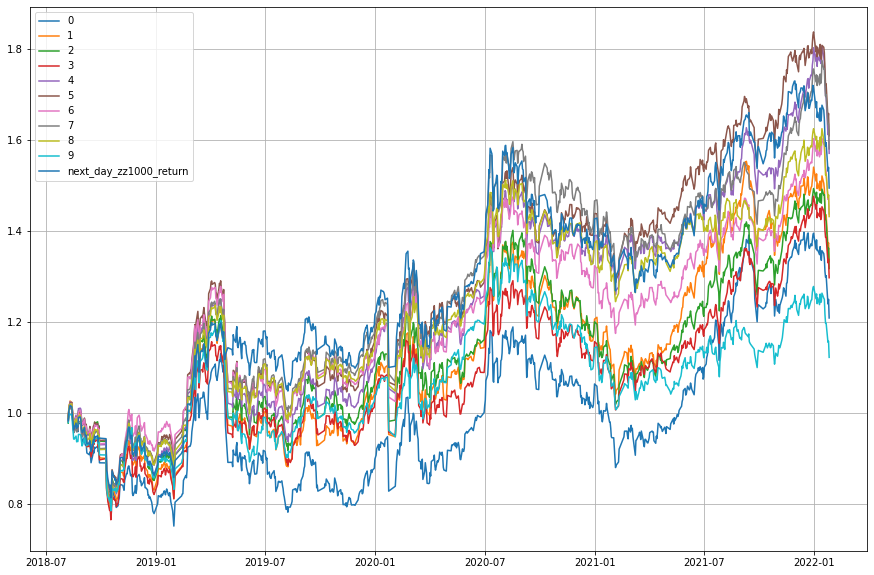

In [29]:
import matplotlib.pyplot as plt
nav = (1 + layer_return).cumprod()
plt.figure(figsize = (15,10))
plt.plot(nav.iloc[:-1,:])
plt.legend(nav.columns[:])
plt.grid()

#### Stratification Test (因子行业市值中性化后)

In [30]:
# 计算每个分层的收益
stratify_df = final_factors_df[["date","code","factor_farout","next_daily_return"]] #使用factor_farout(中性化后的因子)
stratify_df['date'] = stratify_df['date'].astype('datetime64[ns]')

# 因子值从小到大进行分层
stratify_df['layer'] = stratify_df.groupby(['date'], group_keys = False).apply(lambda x: pd.qcut(x.iloc[:, 1], 10, labels = False))

# 计算因子行业市值中性化后每层的收益率
layer_return = stratify_df.groupby(['date','layer'])['next_daily_return'].mean()
layer_return = layer_return.unstack()
layer_return = layer_return.join(market_return_df[['next_day_zz1000_return']], how = 'left').dropna()
layer_return

,0,1,2,3,4,5,6,7,8,9,next_day_zz1000_return
date,,,,,,,,,,,
2018-08-07,-0.022980,-0.020763,-0.014789,-0.015839,-0.015654,-0.017768,-0.011438,-0.014124,-0.010801,-0.013297,-0.01664
2018-08-08,0.025405,0.024744,0.022218,0.017508,0.022942,0.023506,0.022353,0.020747,0.019217,0.017799,0.02238
2018-08-09,0.009126,0.004106,0.009495,0.005422,0.006162,0.007200,0.003632,0.002765,0.006953,0.009845,0.00642
2018-08-10,0.008572,0.004823,0.004965,0.001888,0.004993,0.009793,0.001675,0.001441,0.005537,0.000961,0.00508
2018-08-13,-0.005366,-0.005775,-0.000489,-0.000243,-0.003678,-0.002377,-0.000317,0.000106,0.001834,0.003798,-0.00338
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-21,0.013028,0.007482,0.004929,-0.001151,0.001018,0.000234,-0.005735,-0.007568,-0.007873,-0.004815,0.00496
2022-01-24,-0.032982,-0.034563,-0.043088,-0.038886,-0.045630,-0.048523,-0.043908,-0.048964,-0.047019,-0.037763,-0.03937
2022-01-25,0.005738,0.002774,0.005022,0.000389,0.007033,0.003820,0.000781,0.006269,0.009883,0.008599,0.00532


In [31]:
neutralized_return_table = measurements(layer_return)
neutralized_return_table 

,hpy,annual,sigma,sharpe,rela_annual,rela_sigma,rela_return_IR
0,0.296848,0.082532,0.262219,0.219404,-0.043113,0.107552,-0.400858
1,0.441838,0.118106,0.246089,0.378342,-0.013451,0.083732,-0.160644
2,0.251357,0.070803,0.243386,0.188190,-0.055850,0.084042,-0.664552
3,0.125372,0.036692,0.240120,0.048692,-0.087298,0.091629,-0.952731
4,0.091667,0.027119,0.240498,0.008810,-0.096066,0.097055,-0.989807
5,0.406391,0.109647,0.249552,0.339197,-0.021780,0.103138,-0.211178
6,0.439513,0.117556,0.246407,0.375621,-0.015905,0.105855,-0.150257
7,0.461195,0.122664,0.246852,0.395640,-0.012007,0.112373,-0.106853
8,0.730039,0.182026,0.248237,0.632566,0.040128,0.116827,0.343480
9,0.796053,0.195608,0.249008,0.685151,0.050945,0.127236,0.400394


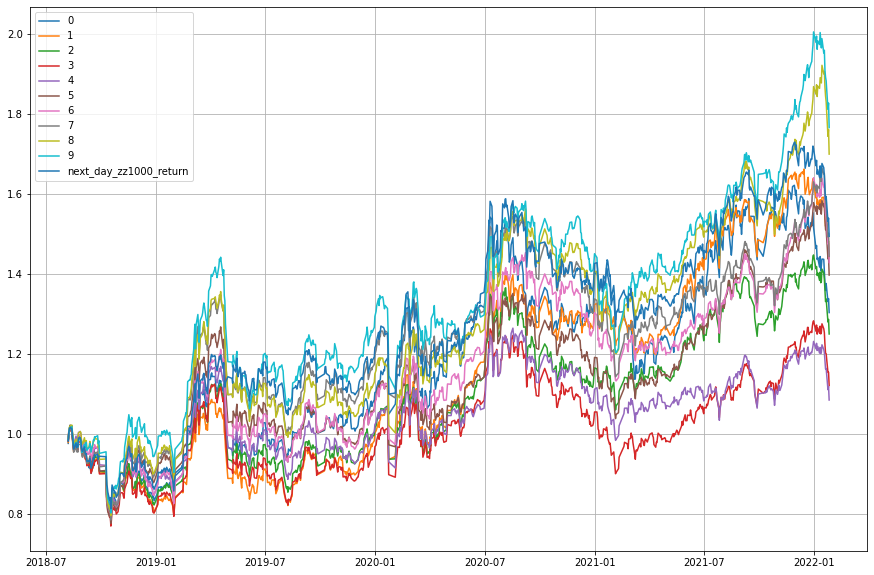

In [32]:
import matplotlib.pyplot as plt
nav = (1 + layer_return).cumprod()
plt.figure(figsize = (15,10))
plt.plot(nav.iloc[:-1,:])
plt.legend(nav.columns[:])
plt.grid()

### Part 2: 指数增强

#### 分层抽样策略

策略简介：
  1. 方法：分层抽样
  2. 概述：使投资组合在市值和行业两个维度上与基准指数保持一致，然后在市值、行业属性比较相似的若干只股票里优选一只因子值最高的进行投资，以获取超额收益。
  3. 本策略的基准指数选中证1000指数。
  4. 选股在基准指数成份股内选股。
  5. 频率：日频

步骤：
 1. 将基准指数成份股按申万一级行业分类分为31个子集，在每个子集中用市值因子将股票划分为数目相等的n组。
 2. 计算每个小组内所有股票在基准指数中的总权重。
 3. 根据因子值，在每个小组中选择因子值最高的一只股票，令这只股票在投资组合中的权重等于它所处小组的权重，选出包含 （31*n）只股票的分层抽样组合。

In [33]:
# 读取中证1000的股票行情
data_df = pd.read_csv('final_factors_zh1000.csv').drop("Unnamed: 0",axis = 1)

# 读取过去两年的数据做回测
data_df = data_df[data_df["date"] <= "2021-12-31"]
data_df

,code,date,weight,display_name,industry_code,industry_name,liquidity_risk_premium,open,close,volume,...,daily_return,daily_ILLIQ,daily_P,daily_C,daily_residuals,LN_market_cap,factor_neutral,factor_farout,next_date,next_daily_return
0,000006.XSHE,2020-06-30,0.137,深振业A,801180,房地产I,0.116382,6.29,6.56,59149833.0,...,0.033071,0.000874,0.742954,0.250195,-0.000096,20.639174,-0.001671,-0.615462,2020-07-01,0.100610
1,000006.XSHE,2020-07-01,0.137,深振业A,801180,房地产I,0.116611,6.45,7.22,109752061.0,...,0.100610,0.001294,0.767757,0.250298,0.000001,20.734350,-0.002014,-0.737990,2020-07-02,-0.001385
2,000006.XSHE,2020-07-02,0.137,深振业A,801180,房地产I,0.116823,7.44,7.21,147483616.0,...,-0.001385,0.000013,0.844419,0.250003,-0.000321,20.733014,-0.001922,-0.705191,2020-07-03,0.004161
3,000006.XSHE,2020-07-03,0.137,深振业A,801180,房地产I,0.116986,7.21,7.24,91479404.0,...,0.004161,0.000063,0.843291,0.250016,-0.000283,20.737017,-0.001907,-0.700143,2020-07-06,0.022099
4,000006.XSHE,2020-07-06,0.137,深振业A,801180,房地产I,0.117055,7.16,7.40,115569080.0,...,0.022099,0.000258,0.846674,0.250066,-0.000177,20.759401,-0.001726,-0.637698,2020-07-07,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845604,688526.XSHG,2021-12-31,0.053,科前生物,801010,农林牧渔I,0.099407,27.56,27.53,2396161.0,...,-0.000726,0.000110,0.872638,0.250029,-0.000495,20.970526,0.000738,0.285446,2022-01-04,0.015983
845624,688568.XSHG,2021-12-31,0.071,中科星图,801750,计算机I,0.099428,77.00,78.98,1254124.0,...,0.033770,0.003434,0.875444,0.250902,0.000212,21.275748,-0.003282,-1.398524,2022-01-04,-0.010889
845644,688586.XSHG,2021-12-31,0.075,江航装备,801740,国防军工I,0.099287,33.47,33.90,3696310.0,...,0.012847,0.001028,0.829286,0.250256,-0.000190,21.037123,-0.000378,-0.182160,2022-01-04,-0.008850
845664,688598.XSHG,2021-12-31,0.312,金博股份,801730,电气设备I,0.099350,343.00,355.04,1736374.0,...,0.064524,0.001055,3.677046,0.251164,0.000780,21.769680,-0.002466,-1.056828,2022-01-04,0.008309


In [34]:
# 读取market return数据/因子数据
market_return_df = pd.read_csv('other_data.csv')
market_return_df['date'] = market_return_df['date'].astype('datetime64[ns]')
market_return_df.set_index('date',inplace = True)
market_return_df = market_return_df.dropna()

# 生成下一期中证1000的收益率
market_return_df['next_day_zz1000_return'] = market_return_df['zz1000_return'].shift(-1)
market_return_df = market_return_df.dropna()
market_return_df

,zz1000,hs300,YTM_2y,zz1000_return,hs300_return,excess_return,next_day_zz1000_return
date,,,,,,,
2018-01-02,"7,092.09","4,087.40",3.7177,0.00956,0.00587,-3.71183,0.00956
2018-01-03,"7,159.88","4,111.39",3.7165,0.00956,0.00587,-3.71063,0.00209
2018-01-04,"7,174.87","4,128.81",3.6772,0.00209,0.00424,-3.67296,0.00028
2018-01-05,"7,176.87","4,138.75",3.6312,0.00028,0.00241,-3.62879,0.00159
2018-01-08,"7,188.29","4,160.16",3.6107,0.00159,0.00517,-3.60553,-0.00161
...,...,...,...,...,...,...,...
2022-03-21,"6,954.41","4,258.75",2.3193,0.01091,-0.00168,-2.32098,-0.00445
2022-03-22,"6,923.44","4,255.30",2.3424,-0.00445,-0.00081,-2.34321,0.00628
2022-03-23,"6,966.95","4,276.52",2.3454,0.00628,0.00499,-2.34041,-0.00949


In [35]:
# 定义行业内按市值进行分组的函数
def get_group(table, num_group = 10):
  '''
    计算分层收益：
    Parameters:
      table: 根据行业分层后的panda table
  '''
  ranks = table['LN_market_cap'].rank(ascending = False)
  label = ['G' + str(i) for i in range(1, num_group + 1)]
  category = pd.cut(ranks, bins = num_group, labels = label) 
  category.name = 'group'
  new_frame = table.join(category)[['LN_market_cap','date','weight','factor_farout','group']]

  return new_frame 

# 计算行业总权重以及因子值最高的股票代码函数
def get_weight_code(data):
  '''
    计算分层收益：
    Parameters:
      data: 当日指数内各行业所含个股
  '''
  df = pd.DataFrame()
  if len(data) <= 10:  #当行业内的股票数在10只以内时，不用分组计算，直接提取对应的权重和股票即可
    df['TargetWeight'] = data['weight']
    df.index = data['group'].values
    df['StockCode'] = data.index.tolist()

  elif len(data) > 10: # 当行业内的股票数大于10只时，需分组计算各组总权重
    grouped = data.groupby('group')
    df = pd.DataFrame()
    df['TargetWeight'] = grouped.sum()['weight']
    df['StockCode'] = [i for i in grouped['factor_farout'].idxmax().values]  #分组提取因子值最小的股票代码

  return df

def stratified_sampling_strategy(table):
  '''
    计算分层收益：
    Parameters:
      table：
        分层个股及其权重
  '''
  dates = list(np.unique(table['date']))  #提取回测区间月末日期
  dates.sort()  #对时间从前往后排序
  dicts = OrderedDict()

  for day in dates:
    ##step1: 在数据集中找出每天中证1000对应的成分股及其权重
    data = table[table['date'] == day]

    ##step2: 对各行业进行分组
    data1 = data.reset_index(drop = True).set_index(['industry_name','code']).sort_index(0) #先对数据按行业和股票代码重新索引,以行业为第一索引
    data2 = data1.groupby(level = 0).apply(get_group) #在各行业内将数据按照市值分为3组

    ##step3: 计算每个小组内所有股票在基准指数中的总权重以及预期收益最高的股票代码
    ind = list(set(data2.index.get_level_values(0)))
    dict_ = OrderedDict()
    
    for i in ind:
      data3 = data2.loc[i]
      dict_[i] = get_weight_code(data3)

    df = pd.concat(dict_.values(), keys = dict_.keys())
    
    ##step4: 归一化
    df['TargetWeight'] = df['TargetWeight']/df['TargetWeight'].sum()
    
    ##step5:提取各期的股票代码和权重
    dicts[day] = df[['StockCode','TargetWeight']]
        
  result = pd.concat(dicts.values(), keys = dicts.keys())
      
  return result

In [36]:
result_df = stratified_sampling_strategy(data_df)

In [37]:
result_df

StockCode  TargetWeight
2018-08-07 非银金融I G9   000416.XSHE      0.000611
                 G2   000666.XSHE      0.000791
                 G1   300176.XSHE      0.003104
                 G5   300309.XSHE      0.001372
                 G3   600093.XSHG      0.000981
...                           ...           ...
2021-12-31 石油石化I G9   300191.XSHE      0.000562
                 G2   600583.XSHG      0.001395
                 G1   600688.XSHG      0.001254
                 G4   600777.XSHG      0.001706
                 G10  600800.XSHG      0.000381

[213331 rows x 2 columns]

In [38]:
# 生成文件
backtest_results = result_df.reset_index()
backtest_results  = backtest_results.rename(columns = {'level_0':"TradingDay",'level_1':"industry_name", "level_2":"group", 'StockCode':'WindCode'})
backtest_results  = backtest_results.drop(columns = ['group','industry_name'])
backtest_results ['WindCode'] = backtest_results['WindCode'].str.replace('XSHG','SH')
backtest_results ['WindCode'] = backtest_results['WindCode'].str.replace('XSHE','SZ')
backtest_results.insert(0, "StrategyName", ["Stratified Sampling" for i in range(1, len(result_df)+1)], True)
backtest_results.insert(1, "InvestmentManager", ["IV001" for i in range(1, len(result_df)+1)], True)
backtest_results.insert(4, "SecuType", ["STOCK" for i in range(1, len(result_df)+1)], True)
backtest_results

,StrategyName,InvestmentManager,TradingDay,WindCode,SecuType,TargetWeight
0,Stratified Sampling,IV001,2018-08-07,000416.SZ,STOCK,0.000611
1,Stratified Sampling,IV001,2018-08-07,000666.SZ,STOCK,0.000791
2,Stratified Sampling,IV001,2018-08-07,300176.SZ,STOCK,0.003104
3,Stratified Sampling,IV001,2018-08-07,300309.SZ,STOCK,0.001372
4,Stratified Sampling,IV001,2018-08-07,600093.SH,STOCK,0.000981
...,...,...,...,...,...,...
213326,Stratified Sampling,IV001,2021-12-31,300191.SZ,STOCK,0.000562
213327,Stratified Sampling,IV001,2021-12-31,600583.SH,STOCK,0.001395
213328,Stratified Sampling,IV001,2021-12-31,600688.SH,STOCK,0.001254
213329,Stratified Sampling,IV001,2021-12-31,600777.SH,STOCK,0.001706


##### 回测

In [39]:
# change the name of the back test data and add daily return
backtest_df = result_df.reset_index().rename(columns = {'level_0':"date",'level_1':"industry_name", "level_2":"group", 'StockCode':'code'})
backtest_df = backtest_df.merge(data_df[["date","next_daily_return","code"]], on = ["date","code"], how = "left")
backtest_df['date'] = backtest_df['date'].astype('datetime64[ns]')
backtest_df = backtest_df.groupby(['date','group'])['next_daily_return'].mean()
backtest_df = backtest_df.unstack()
backtest_df = backtest_df.join(market_return_df[['next_day_zz1000_return']], how='left').dropna()
backtest_df

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,next_day_zz1000_return
date,,,,,,,,,,,
2018-08-07,-0.016355,-0.019976,-0.015338,-0.012715,-0.013369,-0.021034,-0.011614,-0.011917,-0.011626,-0.014276,-0.01664
2018-08-08,0.018307,0.013156,0.021262,0.014896,0.017285,0.018146,0.022303,0.020724,0.014918,0.022985,0.02238
2018-08-09,0.003562,0.002876,-0.000064,0.008331,0.005239,0.002697,0.002094,0.001742,0.001925,0.010625,0.00642
2018-08-10,0.003735,0.004615,0.008465,-0.006210,0.008729,0.002336,0.004903,-0.004046,0.007382,-0.001212,0.00508
2018-08-13,0.001992,-0.001986,-0.004363,-0.003955,-0.003461,0.001318,-0.000819,0.001377,0.005787,0.002878,-0.00338
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.010324,-0.000172,0.007042,0.005278,0.000147,0.004129,0.019061,0.005903,0.003737,0.006093,0.01120
2021-12-28,-0.002961,-0.000295,-0.006485,-0.003080,0.004548,-0.002088,0.004114,0.005931,0.002611,0.004725,-0.00103
2021-12-29,0.012082,0.014691,0.000915,0.014998,0.019171,0.017913,0.020654,0.012630,0.010730,0.010904,0.00880


In [40]:
# 计算各层的收益率
nav = (1 + backtest_df).cumprod()
hpy = nav.iloc[-1, :] - 1
annual = (nav.iloc[-1, :]) ** (252 / len(backtest_df)) - 1
sigma = backtest_df.std() * sqrt(252)
sharpe = (annual - 0.025) / sigma

rela_retn = backtest_df.sub(backtest_df.iloc[:, -1], axis='index')
rela_nav = (1 + rela_retn).cumprod()
rela_annual = (rela_nav.iloc[-1, :]) ** (252 / len(rela_retn)) - 1
rela_sigma = rela_retn.std() * sqrt(252)
rela_return_IR = rela_annual / rela_sigma

result = {'hpy': hpy, 
          'annual': annual, 
          'sigma': sigma,
          'sharpe': sharpe, 
          'rela_annual': rela_annual,
          'rela_sigma': rela_sigma,
          'rela_return_IR': rela_return_IR}

results = pd.DataFrame(result, columns=['hpy', 'annual', 'sigma', 'sharpe',
                                       'rela_annual', 'rela_sigma','rela_return_IR'])

In [41]:
results

,hpy,annual,sigma,sharpe,rela_annual,rela_sigma,rela_return_IR
G1,0.760220,0.192855,0.242583,0.691951,0.002810,0.112859,0.024897
G2,0.361082,0.100921,0.238739,0.318007,-0.075078,0.109973,-0.682692
G3,0.197241,0.057751,0.233895,0.140023,-0.112513,0.110645,-1.016888
G4,0.142929,0.042546,0.234448,0.074839,-0.125647,0.116034,-1.082846
G5,0.477358,0.129430,0.236218,0.442093,-0.052253,0.115325,-0.453093
G6,0.683270,0.176341,0.239568,0.631723,-0.012578,0.119820,-0.104975
G7,0.188258,0.055269,0.242927,0.124602,-0.114478,0.128349,-0.891929
G8,0.481635,0.130449,0.240237,0.438938,-0.051820,0.127320,-0.407003
G9,0.767890,0.194474,0.244548,0.693007,0.001894,0.135276,0.013998
G10,0.437859,0.119924,0.265143,0.358012,-0.060034,0.165883,-0.361902


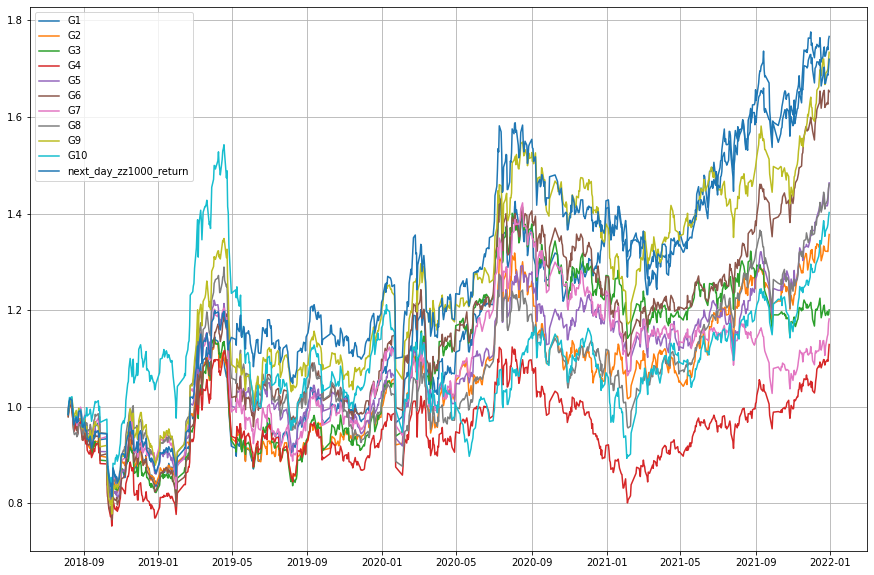

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,10))
plt.plot(nav.iloc[:-1,:])
plt.legend(nav.columns[:])
plt.grid()

##### 未来一段时间的样本外调仓记录

In [43]:
# 读取中证1000成分股每日的权重和所属行业的csv file
zz1000_weight_df = pd.read_csv('zz1000_wi.csv').drop("Unnamed: 0", axis = 1)

# 读取截至2021年的历史中证1000的股票行情
all_stock_factors_final_df = pd.read_csv('all_stock_factors_final_zh1000.csv').drop("Unnamed: 0",axis = 1)
all_stock_factors_final_df["date"] = all_stock_factors_final_df["date"].astype('datetime64[ns]')

In [44]:
# predict the risk factors by using AR
def factor_forecst(factor_table, weight_table, fore_day = 20, order = 3):
  
  # factor table
  df_1 = copy.deepcopy(factor_table)
  df_1["date"] = df_1["date"].astype('datetime64[ns]')
  df_1 = df_1[df_1["date"] > "2021-12-31"]
  share_list = df_1["code"].unique().tolist() 
  forecast_table = pd.DataFrame(index = share_list, 
                                columns = pd.bdate_range(start = '2022-01-01', end = '2022-01-28'))
  
  # weight table
  df_2 = copy.deepcopy(weight_table)
  df_2 = df_2[df_2["date"] > "2021-12-31"]
  df_2["date"] = df_2["date"].astype('datetime64[ns]')


  for share in share_list:
    risk_factor = df_1[df_1["code"] == share]["liquidity_risk_premium"]
    # 剔除停牌的股票
    if len(risk_factor) > order:
      # use AR(3) to forecast the new 20 factor values      
      model = AutoReg(risk_factor, lags = order).fit()
      preds = model.predict(start = len(risk_factor), end = (len(risk_factor) + fore_day - 1))
      forecast_table.loc[share] = np.asarray(preds)

  # 变成可以使用的格式
  forecast_table = forecast_table.dropna()
  forecast_table = forecast_table.T
  forecast_table = forecast_table.reset_index()
  forecast_table = forecast_table.melt('index')
  forecast_table = forecast_table.rename(columns = {'index':'date','variable':'code','value':'liquidity_risk_premium'})
  forecast_table["liquidity_risk_premium"] = forecast_table["liquidity_risk_premium"].astype('float64')
 
  # 加入行业和市值数据
  forecast_table = df_2.merge(forecast_table, on = ['code','date'], how = 'left')
  forecast_table = forecast_table.merge(df_1[['code','date',"market_cap"]], on = ['code','date'], how = 'left')
  forecast_table = forecast_table.dropna()
  
  return forecast_table

In [45]:
# 预测因子值
forecast_df = factor_forecst(all_stock_factors_final_df, zz1000_weight_df)

# 将预测后的因子中性化
faore_neutralized = neutralization(forecast_df)
fore_factors_df = minmax_normal(faore_neutralized)
fore_factors_df

,code,date,weight,display_name,industry_code,industry_name,liquidity_risk_premium,market_cap,LN_market_cap,factor_neutral,factor_farout
0,000006.XSHE,2022-01-04,0.058,深振业A,801180,房地产I,0.100988,61.1548,20.231504,0.001506,0.611833
1,000006.XSHE,2022-01-05,0.058,深振业A,801180,房地产I,0.101082,60.8848,20.227079,0.001479,0.606741
2,000006.XSHE,2022-01-06,0.058,深振业A,801180,房地产I,0.101177,61.0198,20.229294,0.001535,0.631301
3,000006.XSHE,2022-01-07,0.058,深振业A,801180,房地产I,0.101274,61.2898,20.233709,0.001558,0.641449
4,000006.XSHE,2022-01-10,0.058,深振业A,801180,房地产I,0.101373,61.9648,20.244662,0.001578,0.652784
...,...,...,...,...,...,...,...,...,...,...,...
18995,688788.XSHG,2022-01-24,0.042,科思科技,801740,国防军工I,0.102502,94.8785,20.670693,0.000784,0.304985
18996,688788.XSHG,2022-01-25,0.042,科思科技,801740,国防军工I,0.102626,91.9101,20.638907,0.000823,0.316612
18997,688788.XSHG,2022-01-26,0.042,科思科技,801740,国防军工I,0.102753,84.4473,20.554223,0.001236,0.487048
18998,688788.XSHG,2022-01-27,0.042,科思科技,801740,国防军工I,0.102881,81.4032,20.517510,0.001232,0.479217


In [46]:
# 用预测的因子值进行分层抽样
fore_result_df = stratified_sampling_strategy(fore_factors_df)
fore_result_df

StockCode  TargetWeight
2022-01-04 非银金融I G7   000567.XSHE      0.000472
                 G3   000627.XSHE      0.000893
                 G5   000712.XSHE      0.000973
                 G10  002647.XSHE      0.000592
                 G8   002961.XSHE      0.000452
...                           ...           ...
2022-01-28 石油石化I G9   300191.XSHE      0.000582
                 G2   600583.XSHG      0.001555
                 G1   600688.XSHG      0.001334
                 G4   600777.XSHG      0.001876
                 G10  600800.XSHG      0.000421

[5510 rows x 2 columns]

In [47]:
# 生成文件
fore_results = fore_result_df.reset_index()
fore_results = fore_results.rename(columns = {'level_0':"TradingDay",'level_1':"industry_name", "level_2":"group", 'StockCode':'WindCode'})
fore_results = fore_results.drop(columns = ['group','industry_name'])
fore_results['WindCode'] = fore_results['WindCode'].str.replace('XSHG','SH')
fore_results['WindCode'] = fore_results['WindCode'].str.replace('XSHE','SZ')
fore_results.insert(0, "StrategyName", ["Stratified Sampling" for i in range(1, len(fore_result_df)+1)], True)
fore_results.insert(1, "InvestmentManager", ["IV001" for i in range(1, len(fore_result_df)+1)], True)
fore_results.insert(4, "SecuType", ["STOCK" for i in range(1, len(fore_result_df)+1)], True)
fore_results['TradingDay'] = fore_results['TradingDay'].astype('datetime64[ns]')
fore_results

,StrategyName,InvestmentManager,TradingDay,WindCode,SecuType,TargetWeight
0,Stratified Sampling,IV001,2022-01-04,000567.SZ,STOCK,0.000472
1,Stratified Sampling,IV001,2022-01-04,000627.SZ,STOCK,0.000893
2,Stratified Sampling,IV001,2022-01-04,000712.SZ,STOCK,0.000973
3,Stratified Sampling,IV001,2022-01-04,002647.SZ,STOCK,0.000592
4,Stratified Sampling,IV001,2022-01-04,002961.SZ,STOCK,0.000452
...,...,...,...,...,...,...
5505,Stratified Sampling,IV001,2022-01-28,300191.SZ,STOCK,0.000582
5506,Stratified Sampling,IV001,2022-01-28,600583.SH,STOCK,0.001555
5507,Stratified Sampling,IV001,2022-01-28,600688.SH,STOCK,0.001334
5508,Stratified Sampling,IV001,2022-01-28,600777.SH,STOCK,0.001876


In [48]:
# 最后输出的文件（涵盖回测（2022年以前）和预测（2022年以来））
TargetHolding_20220128 =  pd.concat([backtest_results,fore_results])
TargetHolding_20220128['TradingDay'] = TargetHolding_20220128['TradingDay'].astype('datetime64[ns]')
TargetHolding_20220128 # data after 2022 are forecasted weights

,StrategyName,InvestmentManager,TradingDay,WindCode,SecuType,TargetWeight
0,Stratified Sampling,IV001,2018-08-07,000416.SZ,STOCK,0.000611
1,Stratified Sampling,IV001,2018-08-07,000666.SZ,STOCK,0.000791
2,Stratified Sampling,IV001,2018-08-07,300176.SZ,STOCK,0.003104
3,Stratified Sampling,IV001,2018-08-07,300309.SZ,STOCK,0.001372
4,Stratified Sampling,IV001,2018-08-07,600093.SH,STOCK,0.000981
...,...,...,...,...,...,...
5505,Stratified Sampling,IV001,2022-01-28,300191.SZ,STOCK,0.000582
5506,Stratified Sampling,IV001,2022-01-28,600583.SH,STOCK,0.001555
5507,Stratified Sampling,IV001,2022-01-28,600688.SH,STOCK,0.001334
5508,Stratified Sampling,IV001,2022-01-28,600777.SH,STOCK,0.001876


In [49]:
TargetHolding_20220128.to_csv('TargetHolding_20220128.csv')

#### 线性优化策略

In [50]:
def optimizer(params, df, benchmark_df, factor_name):

  mv_param, ind_param, w_param  = params[0], params[1], params[2]   # 设置市值敞口约束，行业敞口约束和权重上限
  date_series = sorted(set(df['date']))
  weight_df = pd.DataFrame()  # 储存每天portfolio weight
  
  for start_date in date_series: 
    temp_df = df[df['date'] == start_date]
    n = len(temp_df) # 股票个数

    ''' objective function（max c⊤w）'''
    # 因为solver default是minimization, 故equivalent to min -c⊤x  
    c = -temp_df[factor_name] #因子值（正向因子，越大越好），由于优化器default是最小化，所以在因子值前面加负号
    
    ''' constraints '''
    # 1. 市值中性化 lb <= G_1 <= ub
    temp_benchmark_df = benchmark_df[benchmark_df['date'] == start_date]
    weighted_avg_market_cap = np.dot(temp_benchmark_df['weight'],temp_benchmark_df['market_cap']) # 计算市值均值

    # 设置市值的upper bound和lower bound 
    ub = (1 + mv_param)*weighted_avg_market_cap
    lb = (1 - mv_param)*weighted_avg_market_cap
    
    # 设置G_1, coefficient是个股的market_cap
    G_1 = np.vstack([
        np.array(temp_df['market_cap']).reshape((1,n)),
        -np.array(temp_df['market_cap']).reshape((1,n))])
    
    # 模型输入格式：G_1 <= h1
    h1 = np.hstack([ub,-lb])

    # 2. 行业市值中性化 lb_2 <= G_2 <= ub_2
    lb_2_list = [] # 储存各行业上限
    ub_2_list = [] # 储存各行业下限
    industry_list = [] # 储存用于计算的各行业权重
    # 每个行业的constraint
    for industry in pd.get_dummies(temp_benchmark_df['industry_name']).T.index:
      mv_indy_weight = temp_benchmark_df.groupby('industry_name').get_group(industry)['weight'] # 所属行业所有股票的权重
      weighted_avg_indy = np.sum(mv_indy_weight) # 计算行业平均

      # 设置市值的upper bound和lower bound，并储存结果进list
      lb_2 = (1 - ind_param)*weighted_avg_indy 
      ub_2 = (1 + ind_param)*weighted_avg_indy
      lb_2_list.append(lb_2)
      ub_2_list.append(ub_2)
      
      # 设置用于计算的各行业权重市值，并储存进list
      industry_temp = ((pd.get_dummies(temp_df['industry_name']).T).loc[industry].values) * 1.
      industry_list.append(industry_temp)

    # 设置G_2, coefficient是所有行业个股的market_cap
    G_2 = np.vstack([
      np.array(industry_list),
      -np.array(industry_list)])
    
    # 模型输入格式：G_2 <= h2
    h2 = np.hstack([np.array(ub_2_list),-np.array(lb_2_list)])

    # 3. 个股权重上限 w_param
    # x_min <= w <= x_max
    x_min = np.zeros(n)
    x_max = w_param*np.ones(n)
    G_w = np.vstack([np.hstack([+np.eye(n)]), np.hstack([-np.eye(n)])])
    # 模型输入格式：G_w <= hw
    hw = np.hstack([x_max, -x_min])
    
    # 4. 权重之和<= 1
    #Ax = b 
    A = np.ones(n).reshape(1,n)
    b = np.ones(1)
    
    # 模型输入和求解  
    c = cvxopt.matrix(c)
    G = cvxopt.matrix(np.vstack([G_1,G_2,G_w, A]))
    h = cvxopt.matrix(np.vstack([h1.reshape(len(h1),1),h2.reshape(len(h2),1),hw.reshape(len(hw),1),b.reshape(len(b),1)]))
    
    solvers.options['glpk'] = {'msg_lev' : 'GLP_MSG_OFF'} #隐藏运行信息
    sol = cvxopt.solvers.lp(c,G,h, solver = 'glpk')
    
    # 求解结果
    weights = pd.Series(sol['x']) 

    # 权重归一化
    weights[weights < 0] = 0
    weights = weights/weights.sum()
    # print('日期：'+str(start_date)+', weight<0个数: '+str(len(weights[weights < 0]))+'___weight>0个数:'+str(len(weights[weights > 0]))+'___sum: ',str(weights.sum()))

    result_df = temp_df[['date','code','industry_name']].assign(weight = weights.values)
    weight_df = weight_df.append(result_df,ignore_index = True)
        
  return weight_df

In [51]:
# 输入处理后的因子值
factors_df = pd.read_csv("final_factors_zh1000.csv", index_col=False)
factors_df.drop(columns='Unnamed: 0',inplace=True)
factors_df['weight'] = factors_df['weight']*0.01 #将百分比换成数值

# 优化器
params = [0.005, 0.005, 0.015]  # 市值敞口约束+-0.005, 行业敞口约束+-0.005, 权重上限为0.015
opt_result_df = optimizer(params, factors_df, factors_df, 'factor_farout') #输出权重结果 (uncomment print line in "optimizer" to view progress)
opt_result_df['date'] = opt_result_df['date'].astype('datetime64')
factors_df['date'] = factors_df['date'].astype('datetime64')

In [52]:
# 生成需要的格式
backtest_opt = opt_result_df[opt_result_df['date'] <= '2021-12-31']
backtest_opt = backtest_opt[(backtest_opt != 0).all(1)] # 剔除不选的股票
backtest_opt = backtest_opt.reset_index(drop=True)
backtest_opt = backtest_opt.rename(columns = {'date':"TradingDay",'code':"WindCode", 'weight':'TargetWeight'})
backtest_opt = backtest_opt.drop(columns = ['industry_name'])
backtest_opt['WindCode'] = backtest_opt['WindCode'].str.replace('XSHG','SH')
backtest_opt['WindCode'] = backtest_opt['WindCode'].str.replace('XSHE','SZ')
backtest_opt.insert(0, "StrategyName", ["Linear Optimization" for i in range(1, len(backtest_opt) + 1)], True)
backtest_opt.insert(1, "InvestmentManager", ["IV001" for i in range(1, len(backtest_opt) + 1)], True)
backtest_opt.insert(4, "SecuType", ["STOCK" for i in range(1, len(backtest_opt)+1)], True)
backtest_opt

,StrategyName,InvestmentManager,TradingDay,WindCode,SecuType,TargetWeight
0,Linear Optimization,IV001,2018-08-07,000416.SZ,STOCK,0.009186
1,Linear Optimization,IV001,2018-08-07,000533.SZ,STOCK,0.015000
2,Linear Optimization,IV001,2018-08-07,000571.SZ,STOCK,0.008547
3,Linear Optimization,IV001,2018-08-07,000576.SZ,STOCK,0.015000
4,Linear Optimization,IV001,2018-08-07,000700.SZ,STOCK,0.015000
...,...,...,...,...,...,...
71541,Linear Optimization,IV001,2021-12-31,605117.SH,STOCK,0.008452
71542,Linear Optimization,IV001,2021-12-31,688086.SH,STOCK,0.015000
71543,Linear Optimization,IV001,2021-12-31,688122.SH,STOCK,0.015000
71544,Linear Optimization,IV001,2021-12-31,688198.SH,STOCK,0.015000


In [53]:
# 合并优化器结果权重和中证1000权重表
opt_result_df_new = pd.merge(opt_result_df.rename(columns = {'weight':'cal_weight'}), 
    factors_df[['date','code','weight','next_daily_return']], 
    on=['date','code'], 
    how='outer')

# 计算每日收益
opt_result_df_new['weighted_return'] = opt_result_df_new['next_daily_return']*opt_result_df_new['cal_weight']
opt_result_df_final = opt_result_df_new.groupby('date').sum()[['weighted_return']].reset_index()

# 中证1000每日表现
#benchmark_return = pd.read_csv("other_data.csv",index_col=False)
benchmark_return = market_return_df.reset_index()
benchmark_return['date'] = benchmark_return['date'].astype('datetime64')

# 总表
return_df = pd.merge(opt_result_df_final, benchmark_return[['date','next_day_zz1000_return']],
                      on='date', how='inner')
return_df = return_df.dropna().set_index('date')

# model累计收益
accum_return_df = np.cumproduct(1 + return_df) # (forces start at 1)

# 累计超额收益
accum_excess_df = np.cumproduct(1 + (return_df['weighted_return'] - return_df['next_day_zz1000_return']))

In [54]:
# 计算年化超额收益
# model 
annualized_geo_return = (accum_return_df.loc[:'2021-12-31']['weighted_return'][-1])**(252/len(accum_return_df.loc[:'2021-12-31'])) - 1
print('model年化收益 = ' + str(np.round(annualized_geo_return*100,3)) + '%')

# benchmark 
annualized_geo_mrkt_return = (accum_return_df.loc[:'2021-12-31']['next_day_zz1000_return'][-1])**(252/len(accum_return_df.loc[:'2021-12-31']))-1

# 超额
annual_excess_return =  (accum_excess_df.loc[:'2021-12-31'][-1])**(252/len(accum_return_df.loc[:'2021-12-31']))-1
print('年化超额收益 = ' + str(np.round(annual_excess_return*100,3)) + '%')

tracking_error = np.std(np.array(return_df.loc[:'2021-12-31']['weighted_return'] - return_df.loc[:'2021-12-31']['next_day_zz1000_return']),ddof = 1)*np.sqrt(252)
print('跟踪误差 = ' + str(np.round(tracking_error*100,3)) + '%')

info_ratio = np.mean(np.array(return_df.loc[:'2021-12-31']['weighted_return'] - return_df.loc[:'2021-12-31']['next_day_zz1000_return']))/tracking_error*252
print('信息比率 = ' + str(np.round(info_ratio,3)))

max_drawdown_model = max_drawdown(return_df.loc[:'2021-12-31']['weighted_return'])*(-1)
max_drawdown_market = max_drawdown(return_df.loc[:'2021-12-31']['next_day_zz1000_return'])*(-1)
relative_max_drawdown = max_drawdown_model - max_drawdown_market
print('最大回撤 = ' + str(np.round(max_drawdown_model*100,3)) + '%') 

model年化收益 = 12.357%
年化超额收益 = -5.467%
跟踪误差 = 10.365%
信息比率 = -0.49
最大回撤 = 27.235%


Text(0.5, 1.0, 'cumulative return record: mv_param=0.005;ind_param=0.005;w_param=0.015')

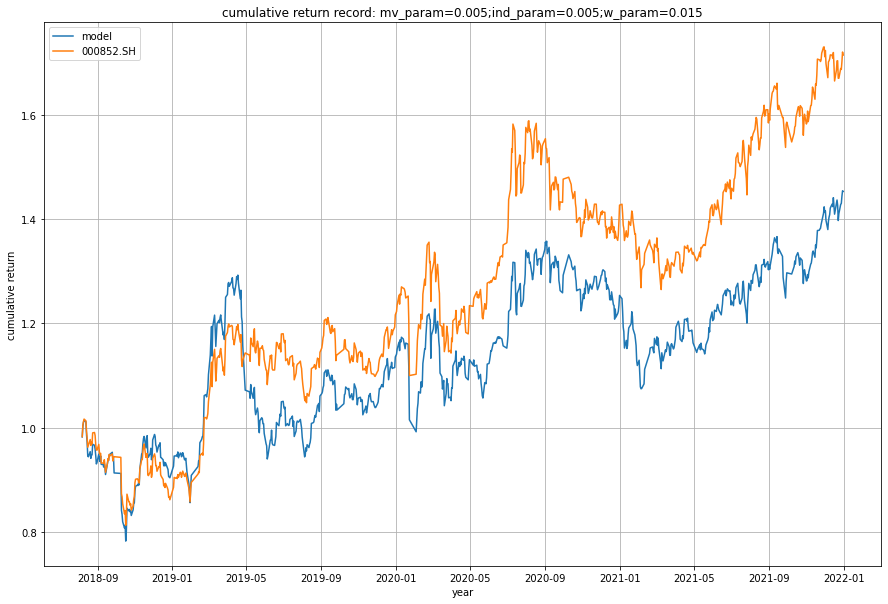

In [55]:
# 绝对收益图
plt.figure(figsize=(15,10))
plt.plot(accum_return_df.loc[:'2021-12-31']['weighted_return'])
plt.plot(accum_return_df.loc[:'2021-12-31']['next_day_zz1000_return'])
plt.legend(['model','000852.SH'])
plt.grid()
plt.ylabel('cumulative return')
plt.xlabel('year')
plt.title('cumulative return record: mv_param='+str(params[0])+';ind_param='+str(params[1])+';w_param='+str(params[2]))

Text(0.5, 1.0, 'excess return record')

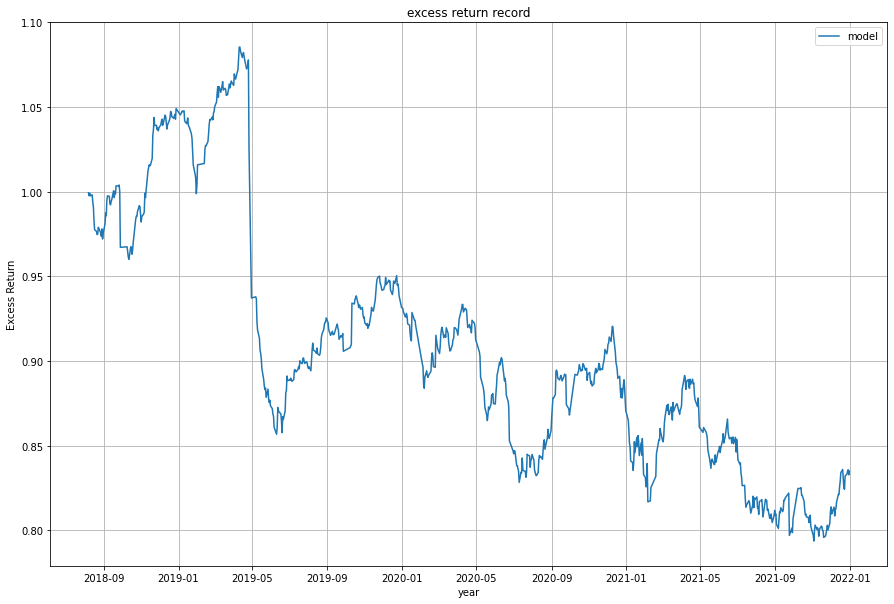

In [56]:
# 超额收益图
plt.figure(figsize=(15,10))
plt.plot(accum_excess_df.loc[:'2021-12-31'])
plt.legend(['model'])
plt.grid()
plt.ylabel('Excess Return')
plt.xlabel('year')
plt.title('excess return record')

##### 未来一段时间的样本外调仓记录

In [57]:
# 优化器
params = [0.005, 0.005, 0.015]  # 市值敞口约束+-0.005, 行业敞口约束+-0.005, 权重上限为0.015
fore_factors_df['weight'] = fore_factors_df['weight']*0.01 #将百分比换成数值   # fore_factors_df 为之前预测的因子值
fore_opt_result_df = optimizer(params, fore_factors_df, fore_factors_df, 'factor_farout') #输出权重结果 (uncomment print line in "optimizer" to view progress)
fore_opt_result_df['date'] = fore_opt_result_df['date'].astype('datetime64[ns]')

In [58]:
fore_opt_result_df

,date,code,industry_name,weight
0,2022-01-04,000006.XSHE,房地产I,0.0
1,2022-01-04,000011.XSHE,房地产I,0.0
2,2022-01-04,000016.XSHE,家用电器I,0.0
3,2022-01-04,000019.XSHE,农林牧渔I,0.0
4,2022-01-04,000025.XSHE,汽车I,0.0
...,...,...,...,...
18816,2022-01-28,688526.XSHG,农林牧渔I,0.0
18817,2022-01-28,688568.XSHG,计算机I,0.0
18818,2022-01-28,688586.XSHG,国防军工I,0.0
18819,2022-01-28,688598.XSHG,电气设备I,0.0


In [59]:
# 生成需要的格式
fore_results_opt = fore_opt_result_df
fore_results_opt = fore_results_opt[(fore_results_opt != 0).all(1)] # 剔除不选的股票（权重为0）
fore_results_opt = fore_results_opt.reset_index(drop=True)
fore_results_opt = fore_results_opt.rename(columns = {'date':"TradingDay",'code':"WindCode", 'weight':'TargetWeight'})
fore_results_opt = fore_results_opt.drop(columns = ['industry_name'])
fore_results_opt['WindCode'] = fore_results_opt['WindCode'].str.replace('XSHG','SH')
fore_results_opt['WindCode'] = fore_results_opt['WindCode'].str.replace('XSHE','SZ')
fore_results_opt.insert(0, "StrategyName", ["Linear Optimization" for i in range(1, len(fore_results_opt) + 1)], True)
fore_results_opt.insert(1, "InvestmentManager", ["IV001" for i in range(1, len(fore_results_opt) + 1)], True)
fore_results_opt.insert(4, "SecuType", ["STOCK" for i in range(1, len(fore_results_opt)+1)], True)
fore_results_opt

,StrategyName,InvestmentManager,TradingDay,WindCode,SecuType,TargetWeight
0,Linear Optimization,IV001,2022-01-04,000032.SZ,STOCK,0.015000
1,Linear Optimization,IV001,2022-01-04,000070.SZ,STOCK,0.007908
2,Linear Optimization,IV001,2022-01-04,000155.SZ,STOCK,0.002301
3,Linear Optimization,IV001,2022-01-04,000507.SZ,STOCK,0.001874
4,Linear Optimization,IV001,2022-01-04,000557.SZ,STOCK,0.015000
...,...,...,...,...,...,...
1629,Linear Optimization,IV001,2022-01-28,603956.SH,STOCK,0.015000
1630,Linear Optimization,IV001,2022-01-28,603976.SH,STOCK,0.015000
1631,Linear Optimization,IV001,2022-01-28,605117.SH,STOCK,0.009055
1632,Linear Optimization,IV001,2022-01-28,688086.SH,STOCK,0.015000


In [60]:
# 最后输出的文件（涵盖回测和预测）
TargetHolding_20220128_LP =  pd.concat([backtest_opt, fore_results_opt])
TargetHolding_20220128_LP['TradingDay'] = TargetHolding_20220128_LP['TradingDay'].astype('datetime64[ns]')
TargetHolding_20220128_LP # data after 2022 are forecasted weigghts

,StrategyName,InvestmentManager,TradingDay,WindCode,SecuType,TargetWeight
0,Linear Optimization,IV001,2018-08-07,000416.SZ,STOCK,0.009186
1,Linear Optimization,IV001,2018-08-07,000533.SZ,STOCK,0.015000
2,Linear Optimization,IV001,2018-08-07,000571.SZ,STOCK,0.008547
3,Linear Optimization,IV001,2018-08-07,000576.SZ,STOCK,0.015000
4,Linear Optimization,IV001,2018-08-07,000700.SZ,STOCK,0.015000
...,...,...,...,...,...,...
1629,Linear Optimization,IV001,2022-01-28,603956.SH,STOCK,0.015000
1630,Linear Optimization,IV001,2022-01-28,603976.SH,STOCK,0.015000
1631,Linear Optimization,IV001,2022-01-28,605117.SH,STOCK,0.009055
1632,Linear Optimization,IV001,2022-01-28,688086.SH,STOCK,0.015000


In [61]:
TargetHolding_20220128_LP.to_csv('TargetHolding_20220128_LP.csv')

结论：根据分层测试的结果，liquidity risk premium存在一定程度的单调性。但在过去两年中（2020年至2022年），对于中证1000指数的日频策略，该因子的超额收益不强。

## 沪深300

### Part 1: Liquidity Risk Premium

#### 读取数据

In [62]:
# 读取股票每日行情的csv file
hs300_panel_df = pd.read_csv('hs300_final.csv').drop("Unnamed: 0", axis = 1)
hs300_panel_df_copy = copy.deepcopy(hs300_panel_df)

# 剔除停牌股票
hs300_panel_df_copy = hs300_panel_df_copy.replace(to_replace = 0, method = 'ffill') # 判断是否是调入后首日停牌
hs300_panel_df_copy = hs300_panel_df_copy[(hs300_panel_df_copy != 0).all(1)] # 剔除首日停牌的股票
hs300_panel_df_copy = hs300_panel_df_copy.reset_index(drop = True)

# display
hs300_panel_df_copy

,date,code,open,close,volume,money,market_cap
0,2018-01-02,000001.XSHE,12.69,13.02,218958168.0,2.856544e+09,2352.3464
1,2018-01-03,000001.XSHE,13.05,12.67,311618726.0,4.006221e+09,2288.8159
2,2018-01-04,000001.XSHE,12.66,12.60,195071797.0,2.454544e+09,2275.0796
3,2018-01-05,000001.XSHE,12.56,12.64,127310148.0,1.603290e+09,2283.6648
4,2018-01-08,000001.XSHE,12.60,12.32,227060603.0,2.806099e+09,2225.2854
...,...,...,...,...,...,...,...
449448,2022-01-24,688981.XSHG,51.28,51.35,8792751.0,4.511799e+08,4058.6304
449449,2022-01-25,688981.XSHG,51.19,50.06,17506190.0,8.844075e+08,3956.6707
449450,2022-01-26,688981.XSHG,50.04,50.31,8416409.0,4.229725e+08,3976.4302
449451,2022-01-27,688981.XSHG,50.29,49.03,16972836.0,8.422811e+08,3875.2610


#### 合成沪深300的Liquidity Risk Premium

In [63]:
# 计算因子的各类数据
data_processed_df_hs300 = data_process(hs300_panel_df_copy, 'daily')

In [64]:
data_processed_df_hs300

,date,code,open,close,volume,money,market_cap,daily_return,daily_ILLIQ,daily_P,daily_C,daily_residuals
20,2018-01-30,000001.XSHE,13.02,12.98,115153292.0,149.770887,2343.7612,-0.006126,0.000041,1.002920,0.250012,-0.000009
21,2018-01-31,000001.XSHE,12.93,13.36,183839806.0,242.310477,2412.4429,0.029276,0.000121,0.996350,0.250036,0.000010
22,2018-02-01,000001.XSHE,13.26,13.34,210966230.0,282.158361,2409.0088,-0.001497,0.000005,1.025547,0.250002,-0.000018
23,2018-02-02,000001.XSHE,13.22,13.36,123754799.0,163.761962,2412.4429,0.001499,0.000009,1.024088,0.250003,-0.000018
24,2018-02-05,000001.XSHE,13.12,13.83,245297760.0,332.635531,2498.2949,0.035180,0.000106,1.025547,0.250033,0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...
449448,2022-01-24,688981.XSHG,51.28,51.35,8792751.0,45.117995,4058.6304,0.001365,0.000030,0.659157,0.250006,-0.000012
449449,2022-01-25,688981.XSHG,51.19,50.06,17506190.0,88.440750,3956.6707,-0.025122,0.000284,0.660057,0.250056,0.000032
449450,2022-01-26,688981.XSHG,50.04,50.31,8416409.0,42.297255,3976.4302,0.004994,0.000118,0.643475,0.250023,0.000005
449451,2022-01-27,688981.XSHG,50.29,49.03,16972836.0,84.228112,3875.2610,-0.025442,0.000302,0.646688,0.250059,0.000032


In [65]:
# 计算每日innovation均值
data_processed_df_copy = data_processed_df_hs300
grouped_multiple = data_processed_df_copy.groupby(['date']).agg({'daily_residuals': ['mean']})
grouped_multiple.columns = ['daily_innovation_mean']
grouped_multiple = grouped_multiple.reset_index()
grouped_multiple["date"]= grouped_multiple["date"].astype("datetime64[ns]")
grouped_multiple

,date,daily_innovation_mean
0,2018-01-30,-0.000036
1,2018-01-31,0.000119
2,2018-02-01,0.000165
3,2018-02-02,-0.000026
4,2018-02-05,0.000052
...,...,...
967,2022-01-24,0.000019
968,2022-01-25,0.000210
969,2022-01-26,-0.000040
970,2022-01-27,0.000194


In [66]:
# 读取沪深300行情, 2年期国债YTM以及excess return
other_data_df = pd.read_csv('other_data.csv').dropna()
other_data_df["date"] = other_data_df["date"].astype("datetime64[ns]")
other_data_df['excess_return'] = other_data_df['excess_return'].astype('float')
other_data_df = other_data_df[["date",'excess_return']]
other_data_df

,date,excess_return
0,2018-01-02,-3.71183
1,2018-01-03,-3.71063
2,2018-01-04,-3.67296
3,2018-01-05,-3.62879
4,2018-01-08,-3.60553
...,...,...
1047,2022-03-22,-2.34321
1048,2022-03-23,-2.34041
1049,2022-03-24,-2.33900
1050,2022-03-25,-2.34155


In [67]:
# 合并表格
merged_df = grouped_multiple.merge(other_data_df,on = 'date', how = 'left')
merged_df["excess_return"] = merged_df["excess_return"].ffill(axis = 0)
merged_df["diff"] = merged_df["excess_return"] - merged_df["daily_innovation_mean"]
merged_df

,date,daily_innovation_mean,excess_return,diff
0,2018-01-30,-0.000036,-3.58987,-3.589834
1,2018-01-31,0.000119,-3.52425,-3.524369
2,2018-02-01,0.000165,-3.50942,-3.509585
3,2018-02-02,-0.000026,-3.51223,-3.512204
4,2018-02-05,0.000052,-3.55182,-3.551872
...,...,...,...,...
967,2022-01-24,0.000019,-2.12065,-2.120669
968,2022-01-25,0.000210,-2.18392,-2.184130
969,2022-01-26,-0.000040,-2.18376,-2.183720
970,2022-01-27,0.000194,-2.20072,-2.200914


In [68]:
# liquidity risk is estimated using daily observations with a 6-month rolling window.
window = 126 # 6-month rolling window
merged_df_2 = merged_df.merge(pd.DataFrame(merged_df["diff"].rolling(window, 
              min_periods = 1).apply(lambda x: (x < 0).count())).rename(
                  columns = {'diff':'rolling_count'}),
                  how = 'left',
                  left_index = True,
                  right_index = True)
merged_df_2

,date,daily_innovation_mean,excess_return,diff,rolling_count
0,2018-01-30,-0.000036,-3.58987,-3.589834,1.0
1,2018-01-31,0.000119,-3.52425,-3.524369,2.0
2,2018-02-01,0.000165,-3.50942,-3.509585,3.0
3,2018-02-02,-0.000026,-3.51223,-3.512204,4.0
4,2018-02-05,0.000052,-3.55182,-3.551872,5.0
...,...,...,...,...,...
967,2022-01-24,0.000019,-2.12065,-2.120669,126.0
968,2022-01-25,0.000210,-2.18392,-2.184130,126.0
969,2022-01-26,-0.000040,-2.18376,-2.183720,126.0
970,2022-01-27,0.000194,-2.20072,-2.200914,126.0


In [69]:
# 挑出需要计算liquidity risk premium的天数
time = merged_df_2[merged_df_2['rolling_count'].gt(15)]['date'].tolist()
stock_list = data_processed_df_copy["code"].unique()
all_stock_factors_df = pd.DataFrame(columns = ['date','code','liquidity_risk_premium'])

# 计算个股的liquidity risk premium
for i in stock_list:
  result_df = data_processed_df_copy[data_processed_df_copy['code'] == i].reset_index(drop = True)
  factor_df = result_df.merge(merged_df_2, on = ['date'], how = 'left')
  factor_df["diff_SQR"] = factor_df["diff"]**2
  factor_df["numerator"] = (-1)*factor_df["diff"]*factor_df['daily_C']
  factor_df["liquidity_risk_premium"] = factor_df["numerator"].rolling(window).sum()/factor_df["diff_SQR"].rolling(window).sum()
  factor_df = factor_df[['date','code','liquidity_risk_premium']].dropna()
  all_stock_factors_df = all_stock_factors_df.append(factor_df)

# 合并所有表格，用于因子中性化
all_stock_factors_df = all_stock_factors_df.reset_index(drop = True)
all_stock_factors_final_df = all_stock_factors_df.merge(data_processed_df_copy, on = ['date','code'], how = 'left')
all_stock_factors_final_df

,date,code,liquidity_risk_premium,open,close,volume,money,market_cap,daily_return,daily_ILLIQ,daily_P,daily_C,daily_residuals
0,2018-08-07,000001.XSHE,0.076200,8.65,8.85,71528760.0,62.435966,1574.5267,0.025492,0.000408,0.652555,0.250080,5.080932e-05
1,2018-08-08,000001.XSHE,0.076338,8.84,8.74,59980317.0,52.752699,1553.9222,-0.012429,0.000236,0.669343,0.250047,1.030259e-05
2,2018-08-09,000001.XSHE,0.076457,8.73,8.97,83583871.0,74.646981,1595.1312,0.026316,0.000353,0.660584,0.250070,3.664603e-05
3,2018-08-10,000001.XSHE,0.076570,8.98,8.91,43944406.0,39.136634,1584.8290,-0.006689,0.000171,0.678102,0.250035,-1.820009e-07
4,2018-08-13,000001.XSHE,0.076672,8.80,8.74,84796768.0,73.694779,1553.9222,-0.019080,0.000259,0.673723,0.250052,1.078556e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
380382,2022-01-24,688981.XSHG,0.100290,51.28,51.35,8792751.0,45.117995,4058.6304,0.001365,0.000030,0.659157,0.250006,-1.179938e-05
380383,2022-01-25,688981.XSHG,0.100374,51.19,50.06,17506190.0,88.440750,3956.6707,-0.025122,0.000284,0.660057,0.250056,3.155745e-05
380384,2022-01-26,688981.XSHG,0.100461,50.04,50.31,8416409.0,42.297255,3976.4302,0.004994,0.000118,0.643475,0.250023,4.774827e-06
380385,2022-01-27,688981.XSHG,0.100542,50.29,49.03,16972836.0,84.228112,3875.2610,-0.025442,0.000302,0.646688,0.250059,3.240323e-05


In [70]:
all_stock_factors_final_df.to_csv("all_stock_factors_final_hs300.csv")

In [71]:
# 读取沪深300成分股每日的权重和所属行业的csv file
hs300_weight_df = pd.read_csv('hs300_wi.csv').drop("Unnamed: 0", axis = 1)
hs300_weight_df["date"] = hs300_weight_df["date"].astype("datetime64[ns]")

# 加入行业数据
final_dataset_df_hs300 = hs300_weight_df.merge(all_stock_factors_final_df, on = ['code','date'], how = 'left')
final_dataset_df_hs300 = final_dataset_df_hs300.dropna()
final_dataset_df_hs300

,code,date,weight,display_name,industry_code,industry_name,liquidity_risk_premium,open,close,volume,money,market_cap,daily_return,daily_ILLIQ,daily_P,daily_C,daily_residuals
43500,000001.XSHE,2018-08-07,0.756,平安银行,801780,银行I,0.076200,8.65,8.85,71528760.0,62.435966,1574.5267,0.025492,0.000408,0.652555,0.250080,0.000051
43501,000002.XSHE,2018-08-07,1.060,万科A,801180,房地产I,0.076203,17.84,18.44,53551070.0,96.916620,2413.1587,0.048323,0.000499,0.640663,0.250096,0.000063
43502,000060.XSHE,2018-08-07,0.113,中金岭南,801050,有色金属I,0.076252,4.25,4.48,30313917.0,13.266006,168.8461,0.061611,0.004644,0.593085,0.250826,0.000628
43503,000063.XSHE,2018-08-07,0.325,中兴通讯,801770,通信I,0.076341,13.16,13.55,135712241.0,180.312998,574.3960,0.037519,0.000208,0.369437,0.250023,-0.000010
43504,000069.XSHE,2018-08-07,0.207,华侨城A,801180,房地产I,0.076239,5.33,5.56,34070769.0,18.711983,523.4204,0.053030,0.002834,0.680766,0.250579,0.000360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297593,600905.XSHG,2022-01-28,0.287,三峡能源,801160,公用事业I,0.100634,6.77,6.86,293607869.0,200.101839,1959.9706,0.019316,0.000097,1.761780,0.250051,0.000020
297594,605499.XSHG,2022-01-28,0.034,东鹏饮料,801120,食品饮料I,0.100921,161.11,155.82,929153.0,14.710637,630.2558,-0.028977,0.001970,2.435239,0.251439,0.000457
297595,688561.XSHG,2022-01-28,0.100,奇安信,801750,计算机I,0.100689,77.07,75.33,2231142.0,16.980269,513.8125,-0.012842,0.000756,0.573470,0.250130,-0.000117
297596,601995.XSHG,2022-01-28,0.068,中金公司,801790,非银金融I,0.100649,44.66,43.45,8576745.0,37.963938,2097.4431,-0.018744,0.000494,1.174536,0.250174,0.000076


In [72]:
final_dataset_df_hs300.to_csv("final_dataset_hs300.csv")

#### 因子市值和行业中性化; 中位数去极值和标准化

In [73]:
final_dataset_df = pd.read_csv('final_dataset_hs300.csv').drop("Unnamed: 0",axis = 1)

In [74]:
factor_neutralized = neutralization(final_dataset_df)
final_factors_df = minmax_normal(factor_neutralized)
final_factors_df

,code,date,weight,display_name,industry_code,industry_name,liquidity_risk_premium,open,close,volume,money,market_cap,daily_return,daily_ILLIQ,daily_P,daily_C,daily_residuals,LN_market_cap,factor_neutral,factor_farout
0,000001.XSHE,2018-08-07,0.756,平安银行,801780,银行I,0.076200,8.65,8.85,71528760.0,62.435966,1574.5267,0.025492,0.000408,0.652555,0.250080,0.000051,23.479806,0.001215,0.415049
1,000002.XSHE,2018-08-07,1.060,万科A,801180,房地产I,0.076203,17.84,18.44,53551070.0,96.916620,2413.1587,0.048323,0.000499,0.640663,0.250096,0.000063,23.906787,-0.005348,-2.067276
2,000060.XSHE,2018-08-07,0.113,中金岭南,801050,有色金属I,0.076252,4.25,4.48,30313917.0,13.266006,168.8461,0.061611,0.004644,0.593085,0.250826,0.000628,21.247083,0.002453,0.883323
3,000063.XSHE,2018-08-07,0.325,中兴通讯,801770,通信I,0.076341,13.16,13.55,135712241.0,180.312998,574.3960,0.037519,0.000208,0.369437,0.250023,-0.000010,22.471415,-0.001179,-0.490311
4,000069.XSHE,2018-08-07,0.207,华侨城A,801180,房地产I,0.076239,5.33,5.56,34070769.0,18.711983,523.4204,0.053030,0.002834,0.680766,0.250579,0.000360,22.378481,-0.000453,-0.216027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253771,600905.XSHG,2022-01-28,0.287,三峡能源,801160,公用事业I,0.100634,6.77,6.86,293607869.0,200.101839,1959.9706,0.019316,0.000097,1.761780,0.250051,0.000020,23.698780,-0.001760,-0.583050
253772,605499.XSHG,2022-01-28,0.034,东鹏饮料,801120,食品饮料I,0.100921,161.11,155.82,929153.0,14.710637,630.2558,-0.028977,0.001970,2.435239,0.251439,0.000457,22.564221,0.003651,1.106199
253773,688561.XSHG,2022-01-28,0.100,奇安信,801750,计算机I,0.100689,77.07,75.33,2231142.0,16.980269,513.8125,-0.012842,0.000756,0.573470,0.250130,-0.000117,22.359954,0.001676,0.489491
253774,601995.XSHG,2022-01-28,0.068,中金公司,801790,非银金融I,0.100649,44.66,43.45,8576745.0,37.963938,2097.4431,-0.018744,0.000494,1.174536,0.250174,0.000076,23.766570,-0.002863,-0.927408


In [75]:
# 加入下一期的个股收益率来做回测
final_factors_df = final_factors_df.groupby('code').apply(
    lambda x: x.assign(
        next_date = lambda x: x['date'].shift(-1))).reset_index(drop = True)

final_factors_df = final_factors_df.groupby('code').apply(
    lambda x: x.assign(
        next_daily_return = lambda x: x['daily_return'].shift(-1))).reset_index(drop = True)

In [76]:
final_factors_df

,code,date,weight,display_name,industry_code,industry_name,liquidity_risk_premium,open,close,volume,...,daily_return,daily_ILLIQ,daily_P,daily_C,daily_residuals,LN_market_cap,factor_neutral,factor_farout,next_date,next_daily_return
0,000001.XSHE,2018-08-07,0.756,平安银行,801780,银行I,0.076200,8.65,8.85,71528760.0,...,0.025492,0.000408,0.652555,0.250080,5.080932e-05,23.479806,0.001215,0.415049,2018-08-08,-0.012429
1,000001.XSHE,2018-08-08,0.756,平安银行,801780,银行I,0.076338,8.84,8.74,59980317.0,...,-0.012429,0.000236,0.669343,0.250047,1.030259e-05,23.466633,0.001221,0.416483,2018-08-09,0.026316
2,000001.XSHE,2018-08-09,0.756,平安银行,801780,银行I,0.076457,8.73,8.97,83583871.0,...,0.026316,0.000353,0.660584,0.250070,3.664603e-05,23.492807,0.001181,0.399772,2018-08-10,-0.006689
3,000001.XSHE,2018-08-10,0.756,平安银行,801780,银行I,0.076570,8.98,8.91,43944406.0,...,-0.006689,0.000171,0.678102,0.250035,-1.820009e-07,23.486327,0.001185,0.401298,2018-08-13,-0.019080
4,000001.XSHE,2018-08-13,0.756,平安银行,801780,银行I,0.076672,8.80,8.74,84796768.0,...,-0.019080,0.000259,0.673723,0.250052,1.078556e-05,23.466633,0.001206,0.408730,2018-08-14,-0.005721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253771,688981.XSHG,2022-01-24,0.463,中芯国际,801080,电子I,0.100290,51.28,51.35,8792751.0,...,0.001365,0.000030,0.659157,0.250006,-1.179938e-05,24.426697,-0.005919,-1.886976,2022-01-25,-0.025122
253772,688981.XSHG,2022-01-25,0.463,中芯国际,801080,电子I,0.100374,51.19,50.06,17506190.0,...,-0.025122,0.000284,0.660057,0.250056,3.155745e-05,24.401254,-0.005924,-1.879955,2022-01-26,0.004994
253773,688981.XSHG,2022-01-26,0.463,中芯国际,801080,电子I,0.100461,50.04,50.31,8416409.0,...,0.004994,0.000118,0.643475,0.250023,4.774827e-06,24.406235,-0.005930,-1.882041,2022-01-27,-0.025442
253774,688981.XSHG,2022-01-27,0.463,中芯国际,801080,电子I,0.100542,50.29,49.03,16972836.0,...,-0.025442,0.000302,0.646688,0.250059,3.240323e-05,24.380464,-0.005962,-1.886372,2022-01-28,0.003875


In [77]:
final_factors_df.to_csv("final_factors_hs300.csv")

#### Stratification Test

In [78]:
# 读取market return数据/因子数据
market_return_df = pd.read_csv('other_data.csv')
market_return_df['date'] = market_return_df['date'].astype('datetime64[ns]')
market_return_df.set_index('date',inplace = True)
market_return_df = market_return_df.dropna()

# 生成下一期沪深300的收益率
market_return_df['next_day_hs300_return'] = market_return_df['hs300_return'].shift(-1)
market_return_df = market_return_df.dropna()
market_return_df

,zz1000,hs300,YTM_2y,zz1000_return,hs300_return,excess_return,next_day_hs300_return
date,,,,,,,
2018-01-02,"7,092.09","4,087.40",3.7177,0.00956,0.00587,-3.71183,0.00587
2018-01-03,"7,159.88","4,111.39",3.7165,0.00956,0.00587,-3.71063,0.00424
2018-01-04,"7,174.87","4,128.81",3.6772,0.00209,0.00424,-3.67296,0.00241
2018-01-05,"7,176.87","4,138.75",3.6312,0.00028,0.00241,-3.62879,0.00517
2018-01-08,"7,188.29","4,160.16",3.6107,0.00159,0.00517,-3.60553,0.00700
...,...,...,...,...,...,...,...
2022-03-21,"6,954.41","4,258.75",2.3193,0.01091,-0.00168,-2.32098,-0.00081
2022-03-22,"6,923.44","4,255.30",2.3424,-0.00445,-0.00081,-2.34321,0.00499
2022-03-23,"6,966.95","4,276.52",2.3454,0.00628,0.00499,-2.34041,-0.00590


In [79]:
# 读取因子值（过去两年)，测试时uncomment就不用读取以上代码
final_factors_df = pd.read_csv('final_factors_hs300.csv').drop("Unnamed: 0",axis = 1)

# 计算每个分层的收益
stratify_df = final_factors_df[["date","code","liquidity_risk_premium","next_daily_return"]] # 使用未中性化的因子(liquidlity_risj_premium)
stratify_df['date'] = stratify_df['date'].astype('datetime64[ns]')

# 因子值从小到大进行分层
stratify_df['layer'] = stratify_df.groupby(['date'], group_keys = False).apply(lambda x: pd.qcut(x.iloc[:, 1], 5, labels = False))

# 计算每一层的收益
layer_return = stratify_df.groupby(['date', 'layer'])['next_daily_return'].mean()
layer_return = layer_return.unstack()
layer_return = layer_return.join(market_return_df[['next_day_hs300_return']], how = 'left').dropna()
layer_return

,0,1,2,3,4,next_day_hs300_return
date,,,,,,
2018-08-07,-0.018838,-0.013610,-0.015506,-0.016364,-0.010583,-0.01614
2018-08-08,0.025268,0.023576,0.027816,0.021503,0.015149,0.02505
2018-08-09,0.003208,0.002683,0.006520,0.006965,0.001592,0.00220
2018-08-10,-0.003449,-0.001237,0.002622,0.000196,-0.000110,-0.00431
2018-08-13,-0.005501,-0.003529,-0.004905,-0.006351,0.001634,-0.00514
...,...,...,...,...,...,...
2022-01-21,-0.001349,0.000524,-0.000009,0.003614,0.006588,0.00155
2022-01-24,-0.025037,-0.030216,-0.025332,-0.024642,-0.025085,-0.02262
2022-01-25,0.009354,0.007946,0.007263,0.000185,0.001282,0.00724


In [80]:
return_table = measurements(layer_return)

In [81]:
return_table

,hpy,annual,sigma,sharpe,rela_annual,rela_sigma,rela_return_IR
0,0.438564,0.117331,0.210341,0.438959,-0.010652,0.083630,-0.127367
1,0.378031,0.102772,0.214945,0.361824,-0.022846,0.086686,-0.263549
2,0.325151,0.089686,0.214236,0.301937,-0.035778,0.099683,-0.358918
3,0.506135,0.133088,0.214765,0.503283,0.003377,0.093587,0.036084
4,0.083565,0.024787,0.215485,-0.000988,-0.093363,0.104875,-0.890234
next_day_hs300_return,0.478198,0.126634,0.205027,0.495711,0.000000,0.000000,NaN


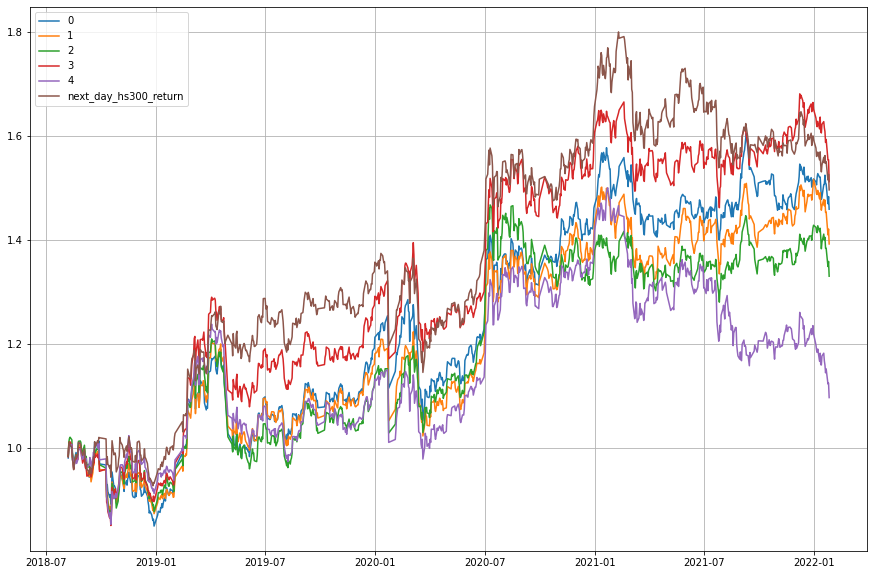

In [82]:
import matplotlib.pyplot as plt
nav = (1 + layer_return).cumprod()
plt.figure(figsize = (15,10))
plt.plot(nav.iloc[:-1,:])
plt.legend(nav.columns[:])
plt.grid()

#### Stratification Test (因子行业市值中性化后)

In [83]:
# 计算每个分层的收益
stratify_df = final_factors_df[["date","code","factor_farout","next_daily_return"]] #使用factor_farout(中性化后的因子)
stratify_df['date'] = stratify_df['date'].astype('datetime64[ns]')

# 因子值从小到大进行分层
stratify_df['layer'] = stratify_df.groupby(['date'], group_keys = False).apply(lambda x: pd.qcut(x.iloc[:, 1], 6, labels = False))

# 计算因子行业市值中性化后每层的收益率
layer_return = stratify_df.groupby(['date','layer'])['next_daily_return'].mean()
layer_return = layer_return.unstack()
layer_return = layer_return.join(market_return_df[['next_day_hs300_return']], how = 'left').dropna()
layer_return

,0,1,2,3,4,5,next_day_hs300_return
date,,,,,,,
2018-08-07,-0.014796,-0.018203,-0.013947,-0.011923,-0.016162,-0.014867,-0.01614
2018-08-08,0.023979,0.023445,0.026374,0.022079,0.024630,0.015413,0.02505
2018-08-09,0.001248,0.004580,0.003586,0.005582,0.005682,0.004477,0.00220
2018-08-10,-0.004170,-0.001493,0.004504,0.003469,-0.000753,-0.003937,-0.00431
2018-08-13,-0.004995,-0.003966,-0.004239,-0.006740,-0.002991,0.000569,-0.00514
...,...,...,...,...,...,...,...
2022-01-21,-0.001674,0.007072,0.006941,0.002940,-0.003030,-0.001011,0.00155
2022-01-24,-0.019463,-0.024074,-0.029451,-0.023210,-0.031410,-0.028886,-0.02262
2022-01-25,0.005218,0.004034,0.002306,0.008575,0.002131,0.008897,0.00724


In [84]:
neutralized_return_table = measurements(layer_return)
neutralized_return_table 

,hpy,annual,sigma,sharpe,rela_annual,rela_sigma,rela_return_IR
0,0.237447,0.067157,0.207602,0.203067,-0.054550,0.068477,-0.796622
1,0.335954,0.092388,0.217236,0.310208,-0.030998,0.079682,-0.389014
2,0.632500,0.161283,0.214821,0.634404,0.028383,0.093556,0.303381
3,0.318068,0.087906,0.216704,0.290284,-0.037160,0.103408,-0.359351
4,0.303999,0.084350,0.215300,0.275659,-0.040945,0.106742,-0.383587
5,0.227521,0.064538,0.218660,0.180822,-0.059037,0.118521,-0.498113
next_day_hs300_return,0.478198,0.126634,0.205027,0.495711,0.000000,0.000000,NaN


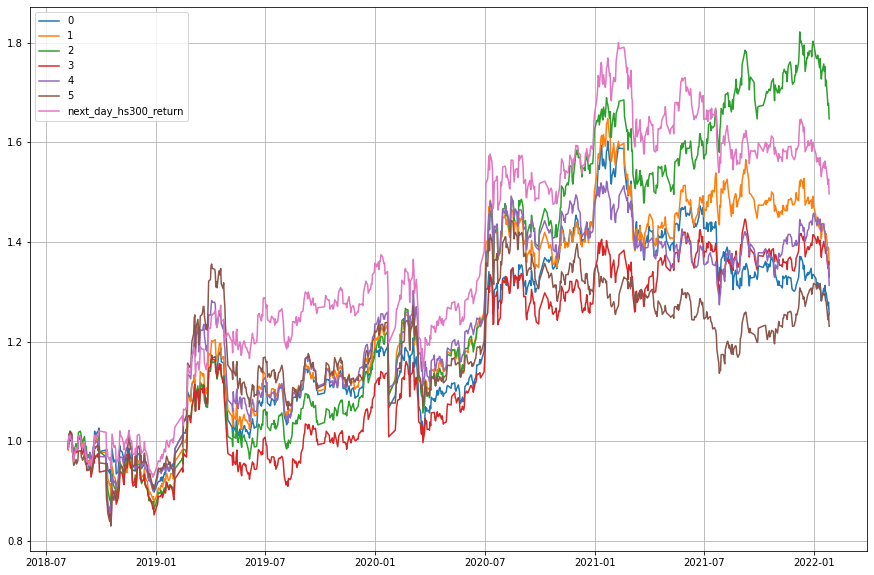

In [85]:
import matplotlib.pyplot as plt
nav = (1 + layer_return).cumprod()
plt.figure(figsize = (15,10))
plt.plot(nav.iloc[:-1,:])
plt.legend(nav.columns[:])
plt.grid()

### Part 2: 指数增强

#### 分层抽样策略

策略简介：
  1. 方法：分层抽样
  2. 概述：使投资组合在市值和行业两个维度上与基准指数保持一致，然后在市值、行业属性比较相似的若干只股票里优选一只因子值最高的进行投资，以获取超额收益。
  3. 本策略的基准指数选中证1000指数。
  4. 选股在基准指数成份股内选股。
  5. 频率：日频

步骤：
 1. 将基准指数成份股按申万一级行业分类分为31个子集，在每个子集中用市值因子将股票划分为数目相等的n组。
 2. 计算每个小组内所有股票在基准指数中的总权重。
 3. 根据因子值，在每个小组中选择因子值最高的一只股票，令这只股票在投资组合中的权重等于它所处小组的权重，选出包含 （31*n）只股票的分层抽样组合。

In [86]:
# 读取沪深300的股票行情
data_df = pd.read_csv('final_factors_hs300.csv').drop("Unnamed: 0",axis = 1)

# 读取过去两年的数据做回测
data_df = data_df[data_df["date"] <= "2021-12-31"]
data_df

,code,date,weight,display_name,industry_code,industry_name,liquidity_risk_premium,open,close,volume,...,daily_return,daily_ILLIQ,daily_P,daily_C,daily_residuals,LN_market_cap,factor_neutral,factor_farout,next_date,next_daily_return
0,000001.XSHE,2018-08-07,0.756,平安银行,801780,银行I,0.076200,8.65,8.85,71528760.0,...,0.025492,0.000408,0.652555,0.250080,5.080932e-05,23.479806,0.001215,0.415049,2018-08-08,-0.012429
1,000001.XSHE,2018-08-08,0.756,平安银行,801780,银行I,0.076338,8.84,8.74,59980317.0,...,-0.012429,0.000236,0.669343,0.250047,1.030259e-05,23.466633,0.001221,0.416483,2018-08-09,0.026316
2,000001.XSHE,2018-08-09,0.756,平安银行,801780,银行I,0.076457,8.73,8.97,83583871.0,...,0.026316,0.000353,0.660584,0.250070,3.664603e-05,23.492807,0.001181,0.399772,2018-08-10,-0.006689
3,000001.XSHE,2018-08-10,0.756,平安银行,801780,银行I,0.076570,8.98,8.91,43944406.0,...,-0.006689,0.000171,0.678102,0.250035,-1.820009e-07,23.486327,0.001185,0.401298,2018-08-13,-0.019080
4,000001.XSHE,2018-08-13,0.756,平安银行,801780,银行I,0.076672,8.80,8.74,84796768.0,...,-0.019080,0.000259,0.673723,0.250052,1.078556e-05,23.466633,0.001206,0.408730,2018-08-14,-0.005721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253695,688396.XSHG,2021-12-30,0.096,华润微,801080,电子I,0.099061,63.60,64.55,8658431.0,...,0.014459,0.000259,1.644396,0.250128,-8.530431e-06,22.865822,0.000206,0.029871,2021-12-31,0.000775
253696,688396.XSHG,2021-12-31,0.077,华润微,801080,电子I,0.099160,64.90,64.60,6577640.0,...,0.000775,0.000018,1.668172,0.250009,-1.333370e-04,22.866596,0.000854,0.236943,2022-01-04,-0.022755
253716,688561.XSHG,2021-12-31,0.108,奇安信,801750,计算机I,0.099176,84.63,87.92,2114831.0,...,0.038875,0.002103,0.635995,0.250401,2.130392e-04,22.514503,0.001411,0.413310,2022-01-04,0.004208
253736,688599.XSHG,2021-12-31,0.294,天合光能,801730,电气设备I,0.099235,79.00,78.90,17798053.0,...,0.045310,0.000319,4.385823,0.250419,7.078159e-05,23.515457,0.000146,0.012879,2022-01-04,-0.085171


In [87]:
# 读取market return数据/因子数据
market_return_df = pd.read_csv('other_data.csv')
market_return_df['date'] = market_return_df['date'].astype('datetime64[ns]')
market_return_df.set_index('date',inplace = True)
market_return_df = market_return_df.dropna()

# 生成下一期沪深300的收益率
market_return_df['next_day_hs300_return'] = market_return_df['hs300_return'].shift(-1)
market_return_df = market_return_df.dropna()
market_return_df

,zz1000,hs300,YTM_2y,zz1000_return,hs300_return,excess_return,next_day_hs300_return
date,,,,,,,
2018-01-02,"7,092.09","4,087.40",3.7177,0.00956,0.00587,-3.71183,0.00587
2018-01-03,"7,159.88","4,111.39",3.7165,0.00956,0.00587,-3.71063,0.00424
2018-01-04,"7,174.87","4,128.81",3.6772,0.00209,0.00424,-3.67296,0.00241
2018-01-05,"7,176.87","4,138.75",3.6312,0.00028,0.00241,-3.62879,0.00517
2018-01-08,"7,188.29","4,160.16",3.6107,0.00159,0.00517,-3.60553,0.00700
...,...,...,...,...,...,...,...
2022-03-21,"6,954.41","4,258.75",2.3193,0.01091,-0.00168,-2.32098,-0.00081
2022-03-22,"6,923.44","4,255.30",2.3424,-0.00445,-0.00081,-2.34321,0.00499
2022-03-23,"6,966.95","4,276.52",2.3454,0.00628,0.00499,-2.34041,-0.00590


In [88]:
# 定义行业内按市值进行分组的函数
def get_group(table, num_group = 6):
  '''
    计算分层收益：
    Parameters:
      table: 根据行业分层后的panda table
  '''
  ranks = table['LN_market_cap'].rank(ascending = False)
  label = ['G' + str(i) for i in range(1, num_group + 1)]
  category = pd.cut(ranks, bins = num_group, labels = label) 
  category.name = 'group'
  new_frame = table.join(category)[['LN_market_cap','date','weight','factor_farout','group']]

  return new_frame 

# 计算行业总权重以及因子值最高的股票代码函数
def get_weight_code(data):
  '''
    计算分层收益：
    Parameters:
      data: 当日指数内各行业所含个股
  '''
  df = pd.DataFrame()
  if len(data) <= 6:  #当行业内的股票数在10只以内时，不用分组计算，直接提取对应的权重和股票即可
    df['TargetWeight'] = data['weight']
    df.index = data['group'].values
    df['StockCode'] = data.index.tolist()

  elif len(data) > 6: # 当行业内的股票数大于10只时，需分组计算各组总权重
    grouped = data.groupby('group')
    df = pd.DataFrame()
    df['TargetWeight'] = grouped.sum()['weight']
    df['StockCode'] = [i for i in grouped['factor_farout'].idxmax().values]  #分组提取因子值最小的股票代码

  return df

def stratified_sampling_strategy(table):
  '''
    计算分层收益：
    Parameters:
      table：
        分层个股及其权重
  '''
  dates = list(np.unique(table['date']))  #提取回测区间月末日期
  dates.sort()  #对时间从前往后排序
  dicts = OrderedDict()

  for day in dates:
    ##step1: 在数据集中找出每天中证1000对应的成分股及其权重
    data = table[table['date'] == day]

    ##step2: 对各行业进行分组
    data1 = data.reset_index(drop = True).set_index(['industry_name','code']).sort_index(0) #先对数据按行业和股票代码重新索引,以行业为第一索引
    data2 = data1.groupby(level = 0).apply(get_group) #在各行业内将数据按照市值分为3组

    ##step3: 计算每个小组内所有股票在基准指数中的总权重以及预期收益最高的股票代码
    ind = list(set(data2.index.get_level_values(0)))
    dict_ = OrderedDict()
    
    for i in ind:
      data3 = data2.loc[i]
      dict_[i] = get_weight_code(data3)

    df = pd.concat(dict_.values(), keys = dict_.keys())
    
    ##step4: 归一化
    df['TargetWeight'] = df['TargetWeight']/df['TargetWeight'].sum()
    
    ##step5:提取各期的股票代码和权重
    dicts[day] = df[['StockCode','TargetWeight']]
        
  result = pd.concat(dicts.values(), keys = dicts.keys())
      
  return result

In [89]:
result_df = stratified_sampling_strategy(data_df)

In [90]:
result_df

StockCode  TargetWeight
2018-08-07 非银金融I G1  601688.XSHG      0.097151
                 G2  601881.XSHG      0.022798
                 G3  600816.XSHG      0.013357
                 G4  600390.XSHG      0.006198
                 G5  600369.XSHG      0.006518
...                          ...           ...
2021-12-31 石油石化I G2  002493.XSHE      0.002504
                 G3  600346.XSHG      0.002202
                 G4  000301.XSHE      0.001267
                 G5  601808.XSHG      0.000402
                 G6  000703.XSHE      0.001056

[116103 rows x 2 columns]

In [91]:
# 生成文件
backtest_results = result_df.reset_index()
backtest_results  = backtest_results.rename(columns = {'level_0':"TradingDay",'level_1':"industry_name", "level_2":"group", 'StockCode':'WindCode'})
backtest_results  = backtest_results.drop(columns = ['group','industry_name'])
backtest_results ['WindCode'] = backtest_results['WindCode'].str.replace('XSHG','SH')
backtest_results ['WindCode'] = backtest_results['WindCode'].str.replace('XSHE','SZ')
backtest_results.insert(0, "StrategyName", ["Stratified Sampling" for i in range(1, len(result_df)+1)], True)
backtest_results.insert(1, "InvestmentManager", ["IV001" for i in range(1, len(result_df)+1)], True)
backtest_results.insert(4, "SecuType", ["STOCK" for i in range(1, len(result_df)+1)], True)
backtest_results

,StrategyName,InvestmentManager,TradingDay,WindCode,SecuType,TargetWeight
0,Stratified Sampling,IV001,2018-08-07,601688.SH,STOCK,0.097151
1,Stratified Sampling,IV001,2018-08-07,601881.SH,STOCK,0.022798
2,Stratified Sampling,IV001,2018-08-07,600816.SH,STOCK,0.013357
3,Stratified Sampling,IV001,2018-08-07,600390.SH,STOCK,0.006198
4,Stratified Sampling,IV001,2018-08-07,600369.SH,STOCK,0.006518
...,...,...,...,...,...,...
116098,Stratified Sampling,IV001,2021-12-31,002493.SZ,STOCK,0.002504
116099,Stratified Sampling,IV001,2021-12-31,600346.SH,STOCK,0.002202
116100,Stratified Sampling,IV001,2021-12-31,000301.SZ,STOCK,0.001267
116101,Stratified Sampling,IV001,2021-12-31,601808.SH,STOCK,0.000402


##### 回测

In [92]:
# change the name of the back test data and add daily return
backtest_df = result_df.reset_index().rename(columns = {'level_0':"date",'level_1':"industry_name", "level_2":"group", 'StockCode':'code'})
backtest_df = backtest_df.merge(data_df[["date","next_daily_return","code"]], on = ["date","code"], how = "left")
backtest_df['date'] = backtest_df['date'].astype('datetime64[ns]')
backtest_df = backtest_df.groupby(['date','group'])['next_daily_return'].mean()
backtest_df = backtest_df.unstack()
backtest_df = backtest_df.join(market_return_df[['next_day_hs300_return']], how='left').dropna()
backtest_df

,G1,G2,G3,G4,G5,G6,next_day_hs300_return
date,,,,,,,
2018-08-07,-0.014591,-0.020601,-0.008697,-0.009722,-0.007267,-0.019589,-0.01614
2018-08-08,0.023889,0.024589,0.021879,0.021869,0.017362,0.024384,0.02505
2018-08-09,0.004115,0.006439,0.003867,0.002323,0.002433,0.004826,0.00220
2018-08-10,0.002935,-0.001398,0.007573,0.001995,-0.002700,0.002907,-0.00431
2018-08-13,0.000198,-0.010505,-0.004809,-0.003720,-0.006649,-0.003296,-0.00514
...,...,...,...,...,...,...,...
2021-12-27,0.003753,0.000334,0.004851,0.005097,0.004802,0.000371,0.00745
2021-12-28,-0.011162,-0.013498,-0.007576,-0.002992,-0.003337,-0.000290,-0.01463
2021-12-29,0.005598,0.006759,0.011706,0.011567,0.001473,0.004865,0.00779


In [93]:
# 计算各层的收益率
nav = (1 + backtest_df).cumprod()
hpy = nav.iloc[-1, :] - 1
annual = (nav.iloc[-1, :]) ** (252 / len(backtest_df)) - 1
sigma = backtest_df.std() * sqrt(252)
sharpe = (annual - 0.025) / sigma

rela_retn = backtest_df.sub(backtest_df.iloc[:, -1], axis='index')
rela_nav = (1 + rela_retn).cumprod()
rela_annual = (rela_nav.iloc[-1, :]) ** (252 / len(rela_retn)) - 1
rela_sigma = rela_retn.std() * sqrt(252)
rela_return_IR = rela_annual / rela_sigma

result = {'hpy': hpy, 
          'annual': annual, 
          'sigma': sigma,
          'sharpe': sharpe, 
          'rela_annual': rela_annual,
          'rela_sigma': rela_sigma,
          'rela_return_IR': rela_return_IR}

results = pd.DataFrame(result, columns=['hpy', 'annual', 'sigma', 'sharpe',
                                       'rela_annual', 'rela_sigma','rela_return_IR'])

In [94]:
results

,hpy,annual,sigma,sharpe,rela_annual,rela_sigma,rela_return_IR
G1,0.448099,0.122406,0.213731,0.455741,-0.031527,0.089927,-0.350584
G2,0.503026,0.135514,0.215834,0.512032,-0.020205,0.094496,-0.213820
G3,0.738408,0.188225,0.223069,0.731727,0.025943,0.104441,0.248403
G4,0.602964,0.158542,0.217486,0.614027,-0.002473,0.118180,-0.020928
G5,0.810038,0.203283,0.214983,0.829292,0.035662,0.117311,0.303999
G6,0.513467,0.137968,0.222364,0.508034,-0.020526,0.129661,-0.158306
next_day_hs300_return,0.592874,0.156263,0.205538,0.638631,0.000000,0.000000,NaN


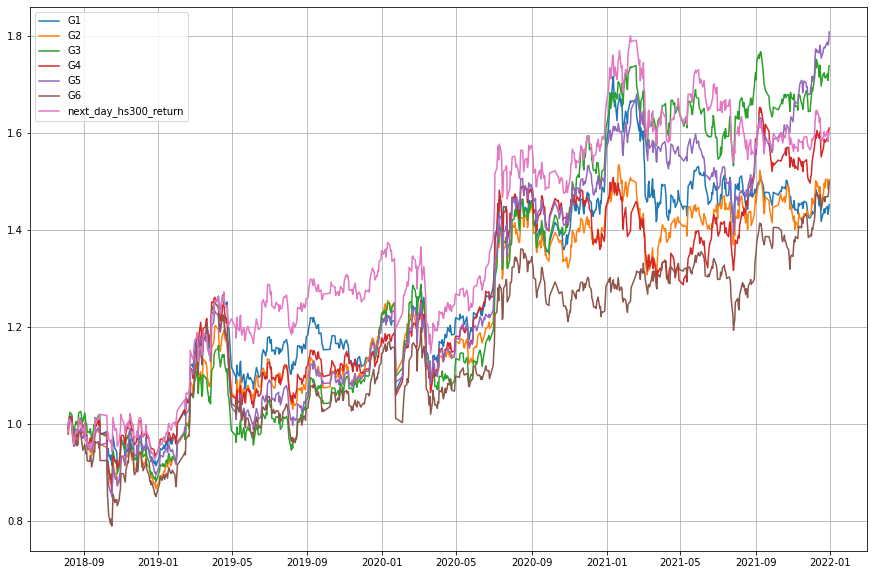

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,10))
plt.plot(nav.iloc[:-1,:])
plt.legend(nav.columns[:])
plt.grid()

##### 未来一段时间的样本外调仓记录

In [96]:
# 读取沪深300成分股每日的权重和所属行业的csv file
hs300_weight_df = pd.read_csv('hs300_wi.csv').drop("Unnamed: 0", axis = 1)

# 读取截至2021年的历史沪深300的股票行情
all_stock_factors_final_df = pd.read_csv('all_stock_factors_final_hs300.csv').drop("Unnamed: 0",axis = 1)
all_stock_factors_final_df["date"] = all_stock_factors_final_df["date"].astype('datetime64[ns]')

In [97]:
# 预测因子值
hs300_forecast_df = factor_forecst(all_stock_factors_final_df, hs300_weight_df)

# 将预测后的因子中性化
hs300_fore_neutralized = neutralization(hs300_forecast_df)
hs300_fore_factors_df = minmax_normal(hs300_fore_neutralized)
hs300_fore_factors_df

,code,date,weight,display_name,industry_code,industry_name,liquidity_risk_premium,market_cap,LN_market_cap,factor_neutral,factor_farout
0,000001.XSHE,2022-01-04,0.721,平安银行,801780,银行I,0.100816,3233.0259,24.199269,-0.001132,-0.388267
1,000002.XSHE,2022-01-04,0.606,万科A,801180,房地产I,0.100810,2382.0410,23.893809,-0.004355,-1.398976
2,000063.XSHE,2022-01-04,0.480,中兴通讯,801770,通信I,0.100814,1580.6063,23.483659,-0.001584,-0.530055
3,000066.XSHE,2022-01-04,0.113,中国长城,801750,计算机I,0.100859,431.1075,22.184453,0.002806,0.846671
4,000069.XSHE,2022-01-04,0.130,华侨城A,801180,房地产I,0.100849,595.4502,22.507413,0.001397,0.404617
...,...,...,...,...,...,...,...,...,...,...,...
5693,600905.XSHG,2022-01-28,0.287,三峡能源,801160,公用事业I,0.101916,1959.9706,23.698780,-0.002594,-0.823175
5694,605499.XSHG,2022-01-28,0.034,东鹏饮料,801120,食品饮料I,0.103124,630.2558,22.564221,0.003765,1.112681
5695,688561.XSHG,2022-01-28,0.100,奇安信,801750,计算机I,0.102910,513.8125,22.359954,0.001734,0.494460
5696,601995.XSHG,2022-01-28,0.068,中金公司,801790,非银金融I,0.102846,2097.4431,23.766570,-0.002927,-0.924559


In [98]:
# 用预测的因子值进行分层抽样
hs300_fore_result_df = stratified_sampling_strategy(hs300_fore_factors_df)
hs300_fore_result_df

StockCode  TargetWeight
2022-01-04 非银金融I G1  601995.XSHG      0.056070
                 G2  601688.XSHG      0.015134
                 G3  601881.XSHG      0.011363
                 G4  601377.XSHG      0.009271
                 G5  000783.XSHE      0.005179
...                          ...           ...
2022-01-28 石油石化I G2  002493.XSHE      0.002667
                 G3  600346.XSHG      0.002436
                 G4  000301.XSHE      0.001193
                 G5  601808.XSHG      0.000411
                 G6  000703.XSHE      0.001083

[2774 rows x 2 columns]

In [99]:
# 生成文件
fore_results = hs300_fore_result_df.reset_index()
fore_results = fore_results.rename(columns = {'level_0':"TradingDay",'level_1':"industry_name", "level_2":"group", 'StockCode':'WindCode'})
fore_results = fore_results.drop(columns = ['group','industry_name'])
fore_results['WindCode'] = fore_results['WindCode'].str.replace('XSHG','SH')
fore_results['WindCode'] = fore_results['WindCode'].str.replace('XSHE','SZ')
fore_results.insert(0, "StrategyName", ["Stratified Sampling" for i in range(1, len(fore_results)+1)], True)
fore_results.insert(1, "InvestmentManager", ["IV001" for i in range(1, len(fore_results)+1)], True)
fore_results.insert(4, "SecuType", ["STOCK" for i in range(1, len(fore_results)+1)], True)
fore_results['TradingDay'] = fore_results['TradingDay'].astype('datetime64[ns]')
fore_results

,StrategyName,InvestmentManager,TradingDay,WindCode,SecuType,TargetWeight
0,Stratified Sampling,IV001,2022-01-04,601995.SH,STOCK,0.056070
1,Stratified Sampling,IV001,2022-01-04,601688.SH,STOCK,0.015134
2,Stratified Sampling,IV001,2022-01-04,601881.SH,STOCK,0.011363
3,Stratified Sampling,IV001,2022-01-04,601377.SH,STOCK,0.009271
4,Stratified Sampling,IV001,2022-01-04,000783.SZ,STOCK,0.005179
...,...,...,...,...,...,...
2769,Stratified Sampling,IV001,2022-01-28,002493.SZ,STOCK,0.002667
2770,Stratified Sampling,IV001,2022-01-28,600346.SH,STOCK,0.002436
2771,Stratified Sampling,IV001,2022-01-28,000301.SZ,STOCK,0.001193
2772,Stratified Sampling,IV001,2022-01-28,601808.SH,STOCK,0.000411


In [100]:
# 最后输出的文件（涵盖回测（2022年以前）和预测（2022年以来））
TargetHolding_20220128 =  pd.concat([backtest_results,fore_results])
TargetHolding_20220128['TradingDay'] = TargetHolding_20220128['TradingDay'].astype('datetime64[ns]')
TargetHolding_20220128 # data after 2022 are forecasted weights

,StrategyName,InvestmentManager,TradingDay,WindCode,SecuType,TargetWeight
0,Stratified Sampling,IV001,2018-08-07,601688.SH,STOCK,0.097151
1,Stratified Sampling,IV001,2018-08-07,601881.SH,STOCK,0.022798
2,Stratified Sampling,IV001,2018-08-07,600816.SH,STOCK,0.013357
3,Stratified Sampling,IV001,2018-08-07,600390.SH,STOCK,0.006198
4,Stratified Sampling,IV001,2018-08-07,600369.SH,STOCK,0.006518
...,...,...,...,...,...,...
2769,Stratified Sampling,IV001,2022-01-28,002493.SZ,STOCK,0.002667
2770,Stratified Sampling,IV001,2022-01-28,600346.SH,STOCK,0.002436
2771,Stratified Sampling,IV001,2022-01-28,000301.SZ,STOCK,0.001193
2772,Stratified Sampling,IV001,2022-01-28,601808.SH,STOCK,0.000411


In [101]:
TargetHolding_20220128.to_csv('TargetHolding_20220128_hs300.csv')

#### 线性优化策略

In [102]:
def optimizer(params, df, benchmark_df, factor_name):

  mv_param, ind_param, w_param  = params[0], params[1], params[2]   # 设置市值敞口约束，行业敞口约束和权重上限
  date_series = sorted(set(df['date']))
  weight_df = pd.DataFrame()  # 储存每天portfolio weight
  
  for start_date in date_series: 
    temp_df = df[df['date'] == start_date]
    n = len(temp_df) # 股票个数

    ''' objective function（max c⊤w）'''
    # 因为solver default是minimization, 故equivalent to min -c⊤x  
    c = -temp_df[factor_name] #因子值（正向因子，越大越好），由于优化器default是最小化，所以在因子值前面加负号
    
    ''' constraints '''
    # 1. 市值中性化 lb <= G_1 <= ub
    temp_benchmark_df = benchmark_df[benchmark_df['date'] == start_date]
    weighted_avg_market_cap = np.dot(temp_benchmark_df['weight'],temp_benchmark_df['market_cap']) # 计算市值均值

    # 设置市值的upper bound和lower bound 
    ub = (1 + mv_param)*weighted_avg_market_cap
    lb = (1 - mv_param)*weighted_avg_market_cap
    
    # 设置G_1, coefficient是个股的market_cap
    G_1 = np.vstack([
        np.array(temp_df['market_cap']).reshape((1,n)),
        -np.array(temp_df['market_cap']).reshape((1,n))])
    
    # 模型输入格式：G_1 <= h1
    h1 = np.hstack([ub,-lb])

    # 2. 行业市值中性化 lb_2 <= G_2 <= ub_2
    lb_2_list = [] # 储存各行业上限
    ub_2_list = [] # 储存各行业下限
    industry_list = [] # 储存用于计算的各行业权重
    # 每个行业的constraint
    for industry in pd.get_dummies(temp_benchmark_df['industry_name']).T.index:
      mv_indy_weight = temp_benchmark_df.groupby('industry_name').get_group(industry)['weight'] # 所属行业所有股票的权重
      weighted_avg_indy = np.sum(mv_indy_weight) # 计算行业平均

      # 设置市值的upper bound和lower bound，并储存结果进list
      lb_2 = (1 - ind_param)*weighted_avg_indy 
      ub_2 = (1 + ind_param)*weighted_avg_indy
      lb_2_list.append(lb_2)
      ub_2_list.append(ub_2)
      
      # 设置用于计算的各行业权重市值，并储存进list
      industry_temp = ((pd.get_dummies(temp_df['industry_name']).T).loc[industry].values) * 1.
      industry_list.append(industry_temp)

    # 设置G_2, coefficient是所有行业个股的market_cap
    G_2 = np.vstack([
      np.array(industry_list),
      -np.array(industry_list)])
    
    # 模型输入格式：G_2 <= h2
    h2 = np.hstack([np.array(ub_2_list),-np.array(lb_2_list)])

    # 3. 个股权重上限 w_param
    # x_min <= w <= x_max
    x_min = np.zeros(n)
    x_max = w_param*np.ones(n)
    G_w = np.vstack([np.hstack([+np.eye(n)]), np.hstack([-np.eye(n)])])
    # 模型输入格式：G_w <= hw
    hw = np.hstack([x_max, -x_min])
    
    # 4. 权重之和<= 1
    #Ax = b 
    A = np.ones(n).reshape(1,n)
    b = np.ones(1)
    
    # 模型输入和求解  
    c = cvxopt.matrix(c)
    G = cvxopt.matrix(np.vstack([G_1,G_2,G_w, A]))
    h = cvxopt.matrix(np.vstack([h1.reshape(len(h1),1),h2.reshape(len(h2),1),hw.reshape(len(hw),1),b.reshape(len(b),1)]))
    
    solvers.options['glpk'] = {'msg_lev' : 'GLP_MSG_OFF'} #隐藏运行信息
    sol = cvxopt.solvers.lp(c,G,h, solver = 'glpk')
    
    # 求解结果
    weights = pd.Series(sol['x']) 

    # 权重归一化
    weights[weights < 0] = 0
    weights = weights/weights.sum()
    # print('日期：'+str(start_date)+', weight<0个数: '+str(len(weights[weights < 0]))+'___weight>0个数:'+str(len(weights[weights > 0]))+'___sum: ',str(weights.sum()))

    result_df = temp_df[['date','code','industry_name']].assign(weight = weights.values)
    weight_df = weight_df.append(result_df,ignore_index = True)
        
  return weight_df

In [103]:
# 输入处理后的因子值
factors_df = pd.read_csv("final_factors_hs300.csv", index_col=False)
factors_df.drop(columns='Unnamed: 0',inplace=True)
factors_df['date'] = factors_df['date'].astype('datetime64')
factors_df['weight'] = factors_df['weight']*0.01 #将百分比换成数值

# 优化器
params = [0.01, 0.01, 0.02]  # 市值敞口约束+-0.005, 行业敞口约束+-0.005, 权重上限为0.015
opt_result_df = optimizer(params, factors_df, factors_df, 'factor_farout') #输出权重结果 (uncomment print line in "optimizer" to view progress)
opt_result_df['date'] = opt_result_df['date'].astype('datetime64')

In [104]:
# 生成需要的格式
backtest_opt = opt_result_df[opt_result_df['date'] <= '2021-12-31']
backtest_opt = backtest_opt[(backtest_opt != 0).all(1)] # 剔除不选的股票
backtest_opt = backtest_opt.reset_index(drop=True)
backtest_opt = backtest_opt.rename(columns = {'date':"TradingDay",'code':"WindCode", 'weight':'TargetWeight'})
backtest_opt = backtest_opt.drop(columns = ['industry_name'])
backtest_opt['WindCode'] = backtest_opt['WindCode'].str.replace('XSHG','SH')
backtest_opt['WindCode'] = backtest_opt['WindCode'].str.replace('XSHE','SZ')
backtest_opt.insert(0, "StrategyName", ["Linear Optimization" for i in range(1, len(backtest_opt) + 1)], True)
backtest_opt.insert(1, "InvestmentManager", ["IV001" for i in range(1, len(backtest_opt) + 1)], True)
backtest_opt.insert(4, "SecuType", ["STOCK" for i in range(1, len(backtest_opt)+1)], True)
backtest_opt

,StrategyName,InvestmentManager,TradingDay,WindCode,SecuType,TargetWeight
0,Linear Optimization,IV001,2018-08-07,000060.SZ,STOCK,2.000000e-02
1,Linear Optimization,IV001,2018-08-07,000333.SZ,STOCK,2.000000e-02
2,Linear Optimization,IV001,2018-08-07,000402.SZ,STOCK,5.153900e-03
3,Linear Optimization,IV001,2018-08-07,000503.SZ,STOCK,2.000000e-02
4,Linear Optimization,IV001,2018-08-07,000559.SZ,STOCK,2.000000e-02
...,...,...,...,...,...,...
56022,Linear Optimization,IV001,2021-12-31,603338.SH,STOCK,2.000000e-02
56023,Linear Optimization,IV001,2021-12-31,603501.SH,STOCK,2.335200e-03
56024,Linear Optimization,IV001,2021-12-31,603658.SH,STOCK,2.250292e-17
56025,Linear Optimization,IV001,2021-12-31,603899.SH,STOCK,2.861100e-03


In [105]:
# 合并优化器结果权重和沪深300权重表
opt_result_df_new = pd.merge(opt_result_df.rename(columns = {'weight':'cal_weight'}), 
    factors_df[['date','code','weight','next_daily_return']], 
    on=['date','code'], 
    how='outer')

# 计算每日收益
opt_result_df_new['weighted_return'] = opt_result_df_new['next_daily_return']*opt_result_df_new['cal_weight']
opt_result_df_final = opt_result_df_new.groupby('date').sum()[['weighted_return']].reset_index()

# 沪深300每日表现
#benchmark_return = pd.read_csv("other_data.csv",index_col=False)
benchmark_return = market_return_df.reset_index()
benchmark_return['date'] = benchmark_return['date'].astype('datetime64')

# 总表
return_df = pd.merge(opt_result_df_final, benchmark_return[['date','next_day_hs300_return']],
                      on='date', how='inner')
return_df = return_df.dropna().set_index('date')

# model累计收益
accum_return_df = np.cumproduct(1 + return_df) # (forces start at 1)

# 累计超额收益
accum_excess_df = np.cumproduct(1 + (return_df['weighted_return'] - return_df['next_day_hs300_return']))

In [106]:
# 计算年化超额收益
# model 
annualized_geo_return = (accum_return_df.loc[:'2021-12-31']['weighted_return'][-1])**(252/len(accum_return_df.loc[:'2021-12-31'])) - 1
print('model年化收益 = ' + str(np.round(annualized_geo_return*100,3)) + '%')

# benchmark 
annualized_geo_mrkt_return = (accum_return_df.loc[:'2021-12-31']['next_day_hs300_return'][-1])**(252/len(accum_return_df.loc[:'2021-12-31']))-1

# 超额
annual_excess_return =  (accum_excess_df.loc[:'2021-12-31'][-1])**(252/len(accum_return_df.loc[:'2021-12-31']))-1
print('年化超额收益 = ' + str(np.round(annual_excess_return*100,3)) + '%')

tracking_error = np.std(np.array(return_df.loc[:'2021-12-31']['weighted_return'] - return_df.loc[:'2021-12-31']['next_day_hs300_return']),ddof = 1)*np.sqrt(252)
print('跟踪误差 = ' + str(np.round(tracking_error*100,3)) + '%')

info_ratio = np.mean(np.array(return_df.loc[:'2021-12-31']['weighted_return'] - return_df.loc[:'2021-12-31']['next_day_hs300_return']))/tracking_error*252
print('信息比率 = ' + str(np.round(info_ratio,3)))

max_drawdown_model = max_drawdown(return_df.loc[:'2021-12-31']['weighted_return'])*(-1)
max_drawdown_market = max_drawdown(return_df.loc[:'2021-12-31']['next_day_hs300_return'])*(-1)
relative_max_drawdown = max_drawdown_model - max_drawdown_market
print('最大回撤 = ' + str(np.round(max_drawdown_model*100,3)) + '%') 

model年化收益 = 7.222%
年化超额收益 = -7.531%
跟踪误差 = 7.187%
信息比率 = -1.053
最大回撤 = 22.618%


Text(0.5, 1.0, 'cumulative return record: mv_param=0.01;ind_param=0.01;w_param=0.02')

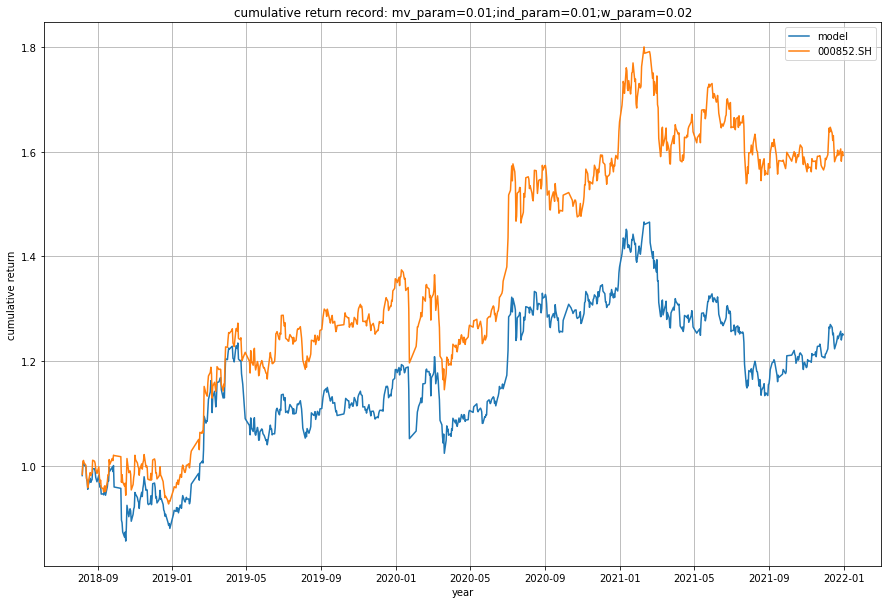

In [107]:
# 绝对收益图
plt.figure(figsize=(15,10))
plt.plot(accum_return_df.loc[:'2021-12-31']['weighted_return'])
plt.plot(accum_return_df.loc[:'2021-12-31']['next_day_hs300_return'])
plt.legend(['model','000852.SH'])
plt.grid()
plt.ylabel('cumulative return')
plt.xlabel('year')
plt.title('cumulative return record: mv_param='+str(params[0])+';ind_param='+str(params[1])+';w_param='+str(params[2]))

Text(0.5, 1.0, 'excess return record')

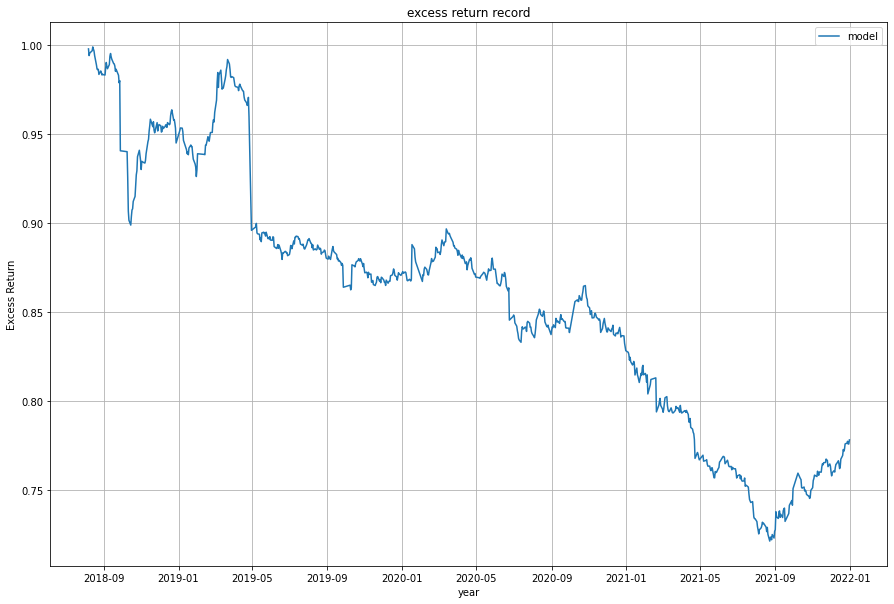

In [108]:
# 超额收益图
plt.figure(figsize=(15,10))
plt.plot(accum_excess_df.loc[:'2021-12-31'])
plt.legend(['model'])
plt.grid()
plt.ylabel('Excess Return')
plt.xlabel('year')
plt.title('excess return record')

##### 未来一段时间的样本外调仓记录

In [109]:
hs300_fore_factors_df

,code,date,weight,display_name,industry_code,industry_name,liquidity_risk_premium,market_cap,LN_market_cap,factor_neutral,factor_farout
0,000001.XSHE,2022-01-04,0.721,平安银行,801780,银行I,0.100816,3233.0259,24.199269,-0.001132,-0.388267
1,000002.XSHE,2022-01-04,0.606,万科A,801180,房地产I,0.100810,2382.0410,23.893809,-0.004355,-1.398976
2,000063.XSHE,2022-01-04,0.480,中兴通讯,801770,通信I,0.100814,1580.6063,23.483659,-0.001584,-0.530055
3,000066.XSHE,2022-01-04,0.113,中国长城,801750,计算机I,0.100859,431.1075,22.184453,0.002806,0.846671
4,000069.XSHE,2022-01-04,0.130,华侨城A,801180,房地产I,0.100849,595.4502,22.507413,0.001397,0.404617
...,...,...,...,...,...,...,...,...,...,...,...
5693,600905.XSHG,2022-01-28,0.287,三峡能源,801160,公用事业I,0.101916,1959.9706,23.698780,-0.002594,-0.823175
5694,605499.XSHG,2022-01-28,0.034,东鹏饮料,801120,食品饮料I,0.103124,630.2558,22.564221,0.003765,1.112681
5695,688561.XSHG,2022-01-28,0.100,奇安信,801750,计算机I,0.102910,513.8125,22.359954,0.001734,0.494460
5696,601995.XSHG,2022-01-28,0.068,中金公司,801790,非银金融I,0.102846,2097.4431,23.766570,-0.002927,-0.924559


In [110]:
# 优化器
params = [0.01, 0.01, 0.02]  # 市值敞口约束+-0.005, 行业敞口约束+-0.005, 权重上限为0.015
hs300_fore_factors_df['weight'] = hs300_fore_factors_df['weight']*0.01 #将百分比换成数值
hs300_fore_opt_result_df = optimizer(params, hs300_fore_factors_df, hs300_fore_factors_df, 'factor_farout') #输出权重结果 (uncomment print line in "optimizer" to view progress)
hs300_fore_opt_result_df['date'] = hs300_fore_opt_result_df['date'].astype('datetime64[ns]')

In [111]:
hs300_fore_opt_result_df

,date,code,industry_name,weight
0,2022-01-04,000001.XSHE,银行I,0.00
1,2022-01-04,000002.XSHE,房地产I,0.00
2,2022-01-04,000063.XSHE,通信I,0.00
3,2022-01-04,000066.XSHE,计算机I,0.00
4,2022-01-04,000069.XSHE,房地产I,0.00
...,...,...,...,...
5651,2022-01-28,600905.XSHG,公用事业I,0.00
5652,2022-01-28,605499.XSHG,食品饮料I,0.00
5653,2022-01-28,688561.XSHG,计算机I,0.00
5654,2022-01-28,601995.XSHG,非银金融I,0.00


In [112]:
# 生成需要的格式
fore_results_opt = hs300_fore_opt_result_df
fore_results_opt = fore_results_opt[(fore_results_opt != 0).all(1)] # 剔除不选的股票（权重为0）
fore_results_opt = fore_results_opt.reset_index(drop=True)
fore_results_opt = fore_results_opt.rename(columns = {'date':"TradingDay",'code':"WindCode", 'weight':'TargetWeight'})
fore_results_opt = fore_results_opt.drop(columns = ['industry_name'])
fore_results_opt['WindCode'] = fore_results_opt['WindCode'].str.replace('XSHG','SH')
fore_results_opt['WindCode'] = fore_results_opt['WindCode'].str.replace('XSHE','SZ')
fore_results_opt.insert(0, "StrategyName", ["Linear Optimization" for i in range(1, len(fore_results_opt) + 1)], True)
fore_results_opt.insert(1, "InvestmentManager", ["IV001" for i in range(1, len(fore_results_opt) + 1)], True)
fore_results_opt.insert(4, "SecuType", ["STOCK" for i in range(1, len(fore_results_opt)+1)], True)
fore_results_opt

,StrategyName,InvestmentManager,TradingDay,WindCode,SecuType,TargetWeight
0,Linear Optimization,IV001,2022-01-04,000425.SZ,STOCK,0.003453
1,Linear Optimization,IV001,2022-01-04,000568.SZ,STOCK,0.020000
2,Linear Optimization,IV001,2022-01-04,000708.SZ,STOCK,0.006747
3,Linear Optimization,IV001,2022-01-04,000858.SZ,STOCK,0.020000
4,Linear Optimization,IV001,2022-01-04,600030.SH,STOCK,0.020000
...,...,...,...,...,...,...
1311,Linear Optimization,IV001,2022-01-28,601698.SH,STOCK,0.013870
1312,Linear Optimization,IV001,2022-01-28,300866.SZ,STOCK,0.016705
1313,Linear Optimization,IV001,2022-01-28,601658.SH,STOCK,0.020000
1314,Linear Optimization,IV001,2022-01-28,300999.SZ,STOCK,0.018119


In [113]:
# 最后输出的文件（涵盖回测和预测）
TargetHolding_20220128_LP =  pd.concat([backtest_opt, fore_results_opt])
TargetHolding_20220128_LP['TradingDay'] = TargetHolding_20220128_LP['TradingDay'].astype('datetime64[ns]')
TargetHolding_20220128_LP # data after 2022 are forecasted weigghts

,StrategyName,InvestmentManager,TradingDay,WindCode,SecuType,TargetWeight
0,Linear Optimization,IV001,2018-08-07,000060.SZ,STOCK,0.020000
1,Linear Optimization,IV001,2018-08-07,000333.SZ,STOCK,0.020000
2,Linear Optimization,IV001,2018-08-07,000402.SZ,STOCK,0.005154
3,Linear Optimization,IV001,2018-08-07,000503.SZ,STOCK,0.020000
4,Linear Optimization,IV001,2018-08-07,000559.SZ,STOCK,0.020000
...,...,...,...,...,...,...
1311,Linear Optimization,IV001,2022-01-28,601698.SH,STOCK,0.013870
1312,Linear Optimization,IV001,2022-01-28,300866.SZ,STOCK,0.016705
1313,Linear Optimization,IV001,2022-01-28,601658.SH,STOCK,0.020000
1314,Linear Optimization,IV001,2022-01-28,300999.SZ,STOCK,0.018119


In [114]:
TargetHolding_20220128_LP.to_csv('TargetHolding_20220128_LP_hs300.csv')

结论：在过去两年中（2020至2022），对于沪深300的日频策略，liquidity risk premium因子存在超额收益，但缺乏明显单调性。